# 230710 - Semi-supervised learning +CBBI Index

## Background

Semi-supervised learning is a type of machine learning where only some of the data is labeled and the goal is to use the labeled data to make predictions on the unlabeled data. Clustering-assisted labeling is a technique used in semi-supervised learning where clustering is used to group similar data points together and then assign labels to these groups.

The basic idea behind clustering-assisted labeling is to use clustering to group similar data points together, and then use the labeled data to assign labels to the clusters. Once the clusters have been labeled, the labels can be propagated to the unlabeled data points in the same cluster.

The advantage of using clustering-assisted labeling is that it allows us to make use of the structure in the data to generate labels for the unlabeled data. This can be particularly useful in cases where labeling the data manually is time-consuming or expensive.

In the context of algo trading, clustering-assisted labeling can be used to create labels for financial data, such as stock prices or exchange rates. The clustering algorithm can be used to group similar data points together based on their attributes, such as volatility or volume. The labeled data can then be used to train a machine learning algorithm to make predictions on the unlabeled data.

To-Do:
- [x] use ETHUSD csv
- [x] merge with CBBI dataframe
- [ ] detect highs with CBBI and lows with tsma120 < price
- [ ] Redo the AIML classification approach

---
## 0. Imports

In [222]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.preprocessing import StandardScaler

import sys
sys.path.append('../../functions_library')

from functions import ROC, model_selection, Backtesting

#import sklearn 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
import sklearn.ensemble

# Classification Metrics 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc #plot_roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# ML models 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import xgboost as xgb

# libraries for Shapely analysis
import shap 

# Visualization libraries
import matplotlib.pyplot as plt
import hvplot.pandas

from bs4 import BeautifulSoup as soup

seed = 42

---
## 1. Data Loading

Read the CSV file into Pandas DataFrame

In [223]:
# Import the OHLCV dataset into a Pandas Dataframe
trading_df = pd.read_csv(
    Path("../../Resources/ETHUSDT-1h-data.csv"), 
    index_col="timestamp", 
    infer_datetime_format=True, 
    parse_dates=True
)

trading_df = trading_df.drop(["close_time","quote_av","trades","tb_base_av","tb_quote_av","ignore"], axis =1)

# Review the DataFrame
trading_df.head()

The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


open    high    low   close     volume
timestamp                                                    
2017-08-17 04:00:00  301.13  302.57  298.0  301.61  125.66877
2017-08-17 05:00:00  301.61  303.28  300.0  303.10  377.67246
2017-08-17 06:00:00  302.40  304.44  301.9  302.68  303.86672
2017-08-17 07:00:00  302.68  307.96  302.6  307.96  754.74510
2017-08-17 08:00:00  307.95  309.97  307.0  308.62  150.75029

In [224]:
# drop duplicate index label
trading_df = trading_df[~trading_df.index.duplicated(keep='first')]

In [225]:
trading_df.tail()

open     high      low    close      volume
timestamp                                                          
2023-06-09 19:00:00  1838.07  1840.35  1830.37  1830.86  11345.8235
2023-06-09 20:00:00  1830.86  1837.11  1828.03  1837.10   7335.9075
2023-06-09 21:00:00  1837.10  1839.83  1834.17  1836.87   6418.9359
2023-06-09 22:00:00  1836.86  1838.49  1835.17  1838.48   4554.0506
2023-06-09 23:00:00  1838.48  1838.62  1836.31  1836.50   1523.9542

Add a daily return values column to the DataFrame

In [226]:
# Calculate the daily returns using the closing prices and the pct_change function
trading_df["actual_returns"] = trading_df["close"].pct_change()

# Drop all NaN values from the DataFrame
trading_df = trading_df.dropna()

# Review the DataFrame
display(trading_df.head())
display(trading_df.tail())

open    high     low   close     volume  actual_returns
timestamp                                                                     
2017-08-17 05:00:00  301.61  303.28  300.00  303.10  377.67246        0.004940
2017-08-17 06:00:00  302.40  304.44  301.90  302.68  303.86672       -0.001386
2017-08-17 07:00:00  302.68  307.96  302.60  307.96  754.74510        0.017444
2017-08-17 08:00:00  307.95  309.97  307.00  308.62  150.75029        0.002143
2017-08-17 09:00:00  308.62  312.00  308.62  310.00  469.27879        0.004472

open     high      low    close      volume  \
timestamp                                                             
2023-06-09 19:00:00  1838.07  1840.35  1830.37  1830.86  11345.8235   
2023-06-09 20:00:00  1830.86  1837.11  1828.03  1837.10   7335.9075   
2023-06-09 21:00:00  1837.10  1839.83  1834.17  1836.87   6418.9359   
2023-06-09 22:00:00  1836.86  1838.49  1835.17  1838.48   4554.0506   
2023-06-09 23:00:00  1838.48  1838.62  1836.31  1836.50   1523.9542   

                     actual_returns  
timestamp                            
2023-06-09 19:00:00       -0.003917  
2023-06-09 20:00:00        0.003408  
2023-06-09 21:00:00       -0.000125  
2023-06-09 22:00:00        0.000876  
2023-06-09 23:00:00       -0.001077

In [227]:
CBBI_json = Path("Resources/CBBI.json")

In [228]:
CBBI_df = pd.read_json(
    CBBI_json,
    #index_col="timestamp", 
    #infer_datetime_format=True, 
    #parse_dates=True,
    #dayfirst=True
    )

In [229]:
#timestamp,value,value_classification
#resample to 1H timeframe
CBBI_df = CBBI_df.resample('1H').ffill()

In [230]:
CBBI_df

Price  PiCycle    RUPL   RHODL   Puell    2YMA  \
2011-06-27 00:00:00     15.590      NaN  0.8152  0.8691  0.7548  0.6390   
2011-06-27 01:00:00     15.590      NaN  0.8152  0.8691  0.7548  0.6390   
2011-06-27 02:00:00     15.590      NaN  0.8152  0.8691  0.7548  0.6390   
2011-06-27 03:00:00     15.590      NaN  0.8152  0.8691  0.7548  0.6390   
2011-06-27 04:00:00     15.590      NaN  0.8152  0.8691  0.7548  0.6390   
...                        ...      ...     ...     ...     ...     ...   
2023-07-02 20:00:00  30584.000   0.5839  0.6308  0.0831  0.6118  0.2201   
2023-07-02 21:00:00  30584.000   0.5839  0.6308  0.0831  0.6118  0.2201   
2023-07-02 22:00:00  30584.000   0.5839  0.6308  0.0831  0.6118  0.2201   
2023-07-02 23:00:00  30584.000   0.5839  0.6308  0.0831  0.6118  0.2201   
2023-07-03 00:00:00  31025.366   0.5847  0.6308  0.0830  0.6119  0.2277   

                     Trolololo    MVRV  ReserveRisk  Woobull  Confidence  
2011-06-27 00:00:00     0.8024  0.5246          NaN   0.5948      0.7143  
2011-06-27 01:00:00     0.8024  0.5246          NaN   0.5948      0.7143  
2011-06-27 02:00:00     0.8024  0.5246          NaN   0.5948      0.7143  
2011-06-27 03:00:00     0.8024  0.5246          NaN   0.5948      0.7143  
2011-06-27 04:00:00     0.8024  0.5246          NaN   0.5948      0.7143  
...                        ...     ...          ...      ...         ...  
2023-07-02 20:00:00     0.1140  0.3047          0.0   0.2687      0.3130  
2023-07-02 21:00:00     0.1140  0.3047          0.0   0.2687      0.3130  
2023-07-02 22:00:00     0.1140  0.3047          0.0   0.2687      0.3130  
2023-07-02 23:00:00     0.1140  0.3047          0.0   0.2687      0.3130  
2023-07-03 00:00:00     0.1202  0.3117          0.0   0.2742      0.3160  

[105337 rows x 11 columns]

In [231]:
CBBI_feats = CBBI_df.columns

In [232]:
CBBI_feats = ['RUPL', 'RHODL', 'Puell', '2YMA', 'Trolololo',
       'MVRV', 'Woobull', 'Confidence']

In [233]:
CBBI_df= CBBI_df[CBBI_feats]

In [234]:
CBBI_df

RUPL   RHODL   Puell    2YMA  Trolololo    MVRV  \
2011-06-27 00:00:00  0.8152  0.8691  0.7548  0.6390     0.8024  0.5246   
2011-06-27 01:00:00  0.8152  0.8691  0.7548  0.6390     0.8024  0.5246   
2011-06-27 02:00:00  0.8152  0.8691  0.7548  0.6390     0.8024  0.5246   
2011-06-27 03:00:00  0.8152  0.8691  0.7548  0.6390     0.8024  0.5246   
2011-06-27 04:00:00  0.8152  0.8691  0.7548  0.6390     0.8024  0.5246   
...                     ...     ...     ...     ...        ...     ...   
2023-07-02 20:00:00  0.6308  0.0831  0.6118  0.2201     0.1140  0.3047   
2023-07-02 21:00:00  0.6308  0.0831  0.6118  0.2201     0.1140  0.3047   
2023-07-02 22:00:00  0.6308  0.0831  0.6118  0.2201     0.1140  0.3047   
2023-07-02 23:00:00  0.6308  0.0831  0.6118  0.2201     0.1140  0.3047   
2023-07-03 00:00:00  0.6308  0.0830  0.6119  0.2277     0.1202  0.3117   

                     Woobull  Confidence  
2011-06-27 00:00:00   0.5948      0.7143  
2011-06-27 01:00:00   0.5948      0.7143  
2011-06-27 02:00:00   0.5948      0.7143  
2011-06-27 03:00:00   0.5948      0.7143  
2011-06-27 04:00:00   0.5948      0.7143  
...                      ...         ...  
2023-07-02 20:00:00   0.2687      0.3130  
2023-07-02 21:00:00   0.2687      0.3130  
2023-07-02 22:00:00   0.2687      0.3130  
2023-07-02 23:00:00   0.2687      0.3130  
2023-07-03 00:00:00   0.2742      0.3160  

[105337 rows x 8 columns]

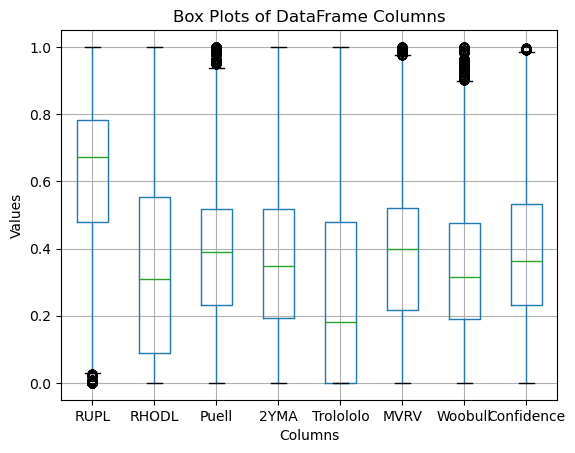

In [235]:
CBBI_df.boxplot()

# Set labels and title
plt.xlabel('Columns')
plt.ylabel('Values')
plt.title('Box Plots of DataFrame Columns')

# Show the plot
plt.show()

In [236]:
# Cut off for 'RUPL'
cutoffs = [-0.1, 0.2, 0.5, 0.7, 0.8, 1.1]
labels = ['very_low','low', 'low-mid', 'mid-high', 'high']

CBBI_df['RUPL#'] = pd.cut(CBBI_df['RUPL'], bins=cutoffs, labels=labels)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [237]:
# Cut off for 'RHODL'
cutoffs = [-0.1, 0.1, 0.3, 0.5, 1.1]
labels = ['low', 'low-mid', 'mid-high', 'high']

CBBI_df['RHODL#'] = pd.cut(CBBI_df['RHODL'], bins=cutoffs, labels=labels)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [238]:
# Cut off for 'Puell'
cutoffs = [-0.1, 0.25, 0.4, 0.5, 0.8,1.1]
labels = ['low', 'low-mid', 'mid-high', 'high','very-high']

CBBI_df['Puell#'] = pd.cut(CBBI_df['Puell'], bins=cutoffs, labels=labels)

In [239]:
# Cut off for '2YMA'
cutoffs = [-0.1, 0.2, 0.35, 0.5,1.1]
labels = ['low', 'low-mid', 'mid-high', 'high']

CBBI_df['2YMA#'] = pd.cut(CBBI_df['2YMA'], bins=cutoffs, labels=labels)

In [240]:
# Cut off for 'TRO'
cutoffs = [-0.1, 0.05, 0.2, 0.5,1.1]
labels = ['very-low', 'low-mid', 'mid-high', 'high']

CBBI_df['TRO#'] = pd.cut(CBBI_df['Trolololo'], bins=cutoffs, labels=labels)

In [241]:
# # Cut off for 'MVRV'
cutoffs = [-0.1, 0.3, 0.4, 0.5,0.8,1.1]
labels = ['low', 'low-mid', 'mid-high', 'high','very-high']

CBBI_df['MVRV#'] = pd.cut(CBBI_df['MVRV'], bins=cutoffs, labels=labels)

In [242]:
# Cut off for 'Confidence'
cutoffs = [-0.1, 0.1,0.2,0.3, 0.4, 0.5,0.6,0.7,0.8,0.9,1.1]
labels = ['X-low','very-low','low', 'low-mid', 'mid','mid-high', 'upper-mid','high','very-high','X-high']

CBBI_df['Confidence#'] = pd.cut(CBBI_df['Confidence'], bins=cutoffs, labels=labels)

In [243]:
CBBI_df = CBBI_df[['Confidence', 'RUPL#', 'RHODL#', 'Puell#', '2YMA#', 'TRO#', 'MVRV#',
       'Confidence#']]

In [244]:
CBBI_df.columns

Index(['Confidence', 'RUPL#', 'RHODL#', 'Puell#', '2YMA#', 'TRO#', 'MVRV#',
       'Confidence#'],
      dtype='object')

In [245]:
fng_df = CBBI_df[['Confidence','Confidence#']]

In [246]:
fng_df

Confidence Confidence#
2011-06-27 00:00:00      0.7143        high
2011-06-27 01:00:00      0.7143        high
2011-06-27 02:00:00      0.7143        high
2011-06-27 03:00:00      0.7143        high
2011-06-27 04:00:00      0.7143        high
...                         ...         ...
2023-07-02 20:00:00      0.3130     low-mid
2023-07-02 21:00:00      0.3130     low-mid
2023-07-02 22:00:00      0.3130     low-mid
2023-07-02 23:00:00      0.3130     low-mid
2023-07-03 00:00:00      0.3160     low-mid

[105337 rows x 2 columns]

In [247]:
# rename column 'B' to 'C'
fng_df = fng_df.rename(columns={'Confidence#': 'fng_classification'})
fng_df = fng_df.rename(columns={'Confidence': 'fng_value'})


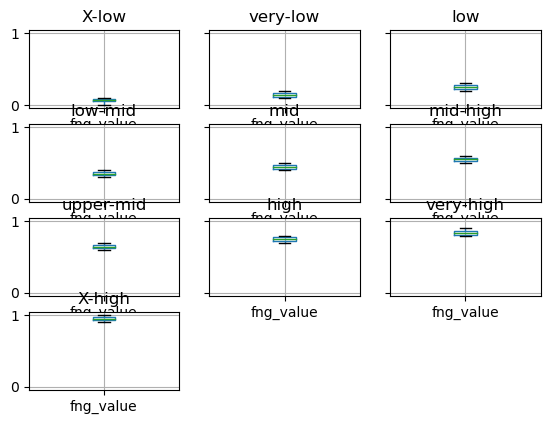

In [248]:
# Group by fng_classification and display boxplots for other columns
fng_df.groupby("fng_classification").boxplot(column=["fng_value"])

# Show the plot
plt.show()

In [249]:
merged_df = pd.merge(fng_df, trading_df, how='inner', left_index=True, right_index=True)

In [250]:
merged_df.dropna()

fng_value fng_classification     open     high      low  \
2017-08-17 05:00:00     0.7207               high   301.61   303.28   300.00   
2017-08-17 06:00:00     0.7207               high   302.40   304.44   301.90   
2017-08-17 07:00:00     0.7207               high   302.68   307.96   302.60   
2017-08-17 08:00:00     0.7207               high   307.95   309.97   307.00   
2017-08-17 09:00:00     0.7207               high   308.62   312.00   308.62   
...                        ...                ...      ...      ...      ...   
2023-06-09 19:00:00     0.2563                low  1838.07  1840.35  1830.37   
2023-06-09 20:00:00     0.2563                low  1830.86  1837.11  1828.03   
2023-06-09 21:00:00     0.2563                low  1837.10  1839.83  1834.17   
2023-06-09 22:00:00     0.2563                low  1836.86  1838.49  1835.17   
2023-06-09 23:00:00     0.2563                low  1838.48  1838.62  1836.31   

                       close       volume  actual_returns  
2017-08-17 05:00:00   303.10    377.67246        0.004940  
2017-08-17 06:00:00   302.68    303.86672       -0.001386  
2017-08-17 07:00:00   307.96    754.74510        0.017444  
2017-08-17 08:00:00   308.62    150.75029        0.002143  
2017-08-17 09:00:00   310.00    469.27879        0.004472  
...                      ...          ...             ...  
2023-06-09 19:00:00  1830.86  11345.82350       -0.003917  
2023-06-09 20:00:00  1837.10   7335.90750        0.003408  
2023-06-09 21:00:00  1836.87   6418.93590       -0.000125  
2023-06-09 22:00:00  1838.48   4554.05060        0.000876  
2023-06-09 23:00:00  1836.50   1523.95420       -0.001077  

[50819 rows x 8 columns]

In [251]:
merged_df

fng_value fng_classification     open     high      low  \
2017-08-17 05:00:00     0.7207               high   301.61   303.28   300.00   
2017-08-17 06:00:00     0.7207               high   302.40   304.44   301.90   
2017-08-17 07:00:00     0.7207               high   302.68   307.96   302.60   
2017-08-17 08:00:00     0.7207               high   307.95   309.97   307.00   
2017-08-17 09:00:00     0.7207               high   308.62   312.00   308.62   
...                        ...                ...      ...      ...      ...   
2023-06-09 19:00:00     0.2563                low  1838.07  1840.35  1830.37   
2023-06-09 20:00:00     0.2563                low  1830.86  1837.11  1828.03   
2023-06-09 21:00:00     0.2563                low  1837.10  1839.83  1834.17   
2023-06-09 22:00:00     0.2563                low  1836.86  1838.49  1835.17   
2023-06-09 23:00:00     0.2563                low  1838.48  1838.62  1836.31   

                       close       volume  actual_returns  
2017-08-17 05:00:00   303.10    377.67246        0.004940  
2017-08-17 06:00:00   302.68    303.86672       -0.001386  
2017-08-17 07:00:00   307.96    754.74510        0.017444  
2017-08-17 08:00:00   308.62    150.75029        0.002143  
2017-08-17 09:00:00   310.00    469.27879        0.004472  
...                      ...          ...             ...  
2023-06-09 19:00:00  1830.86  11345.82350       -0.003917  
2023-06-09 20:00:00  1837.10   7335.90750        0.003408  
2023-06-09 21:00:00  1836.87   6418.93590       -0.000125  
2023-06-09 22:00:00  1838.48   4554.05060        0.000876  
2023-06-09 23:00:00  1836.50   1523.95420       -0.001077  

[50819 rows x 8 columns]

---
## 2. Feature Engineering

# drop duplicate index label
merged_df = merged_df[~merged_df.index.duplicated(keep='first')]

In [252]:
import finta as ft
from finta import TA
import talib

ohlcv_df = merged_df

# List of time periods to use for Moving Averages calculation
timeperiods = [5,7,14,20,30,50,70,100,150,200]

df_eng = ohlcv_df.copy()

# Calculate SMAs and add them to the DataFrame
for t in timeperiods:
    #tsma = TA.SMA(df_eng t).shift(1)
    sma = TA.SMA(df_eng,t)
    ema = TA.EMA(df_eng,t)
    atr = TA.ATR(df_eng,t)  #Average True Range
    adx = TA.ADX(df_eng,t) 
    rsi = TA.RSI(df_eng,t)
    hma = TA.HMA(df_eng,t)
    vama = TA.VAMA(df_eng,t)
 
    # calculate the Force Index
    force_index = pd.Series(df_eng['close'].diff(1) * df_eng['volume'], index=df_eng.index)
    force_ema = force_index.ewm(span=t, min_periods=0, adjust=True, ignore_na=False).mean()    
    
    #df['force_index'] = force_index
    #df[f'force_index_ema_{t}'] = force_ema # add the Force Index and its EMA to the DataFrame
    #df[f'TSMA_{t}'] = tsma
    df_eng[f'SMA_{t}'] = sma
    df_eng[f'EMA_{t}'] = ema
    df_eng[f'HMA_{t}'] = hma
    df_eng[f'VAMA_{t}'] = vama
    df_eng[f'ATR_{t}'] = atr
    df_eng[f'ADX_{t}'] = adx
    df_eng[f'RSI_{t}'] = rsi
    
    
# Calculate the Parabolic SAR
#sar = TA.PSAR(df)

# Add the SAR values and trend direction to the DataFrame
#df['sar'] = sar['psar']
#df['psarbear'] = sar['psarbear']
#df['psarbull'] = sar['psarbull']

df_eng['UO'] = TA.UO(df_eng)

# Adding Awesome Indicator (AO)
df_eng['AO'] = TA.AO(df_eng)
df_eng['OBV'] =TA.OBV(df_eng)

# Adding Chaikin Indicator 
df_eng['CHAIKIN'] = TA.CHAIKIN(df_eng)

# Adding Bollinger Bands
df_eng[['BB_UPPER','BB_MED','BB_LOWER']] =TA.BBANDS(df_eng)

# Calculate the Keltner Channel with TALIB
#df[['KC_UPPER','KC_MED','KC_LOWER']] = TA.KC(df)

# calculate Commodity Channel Index (CCI)
df_eng['cci'] = TA.CCI(df_eng)

# assuming you have OHLCV data in a pandas dataframe called "df"
#volume_momentum = talib.MOM(df['volume'])

In [253]:
# check for duplicate index labels
print(df_eng.index.duplicated().any())

False


In [254]:
# drop duplicate index label
df_eng = df_eng[~df_eng.index.duplicated(keep='first')]


In [255]:
df_eng.dropna()

fng_value fng_classification     open     high      low  \
2017-09-02 19:00:00     0.7414               high   340.23   341.47   334.93   
2017-09-02 20:00:00     0.7414               high   338.08   338.47   325.63   
2017-09-02 21:00:00     0.7414               high   327.16   331.08   320.08   
2017-09-02 22:00:00     0.7414               high   325.45   340.10   325.45   
2017-09-02 23:00:00     0.7414               high   331.77   343.15   329.72   
...                        ...                ...      ...      ...      ...   
2023-06-09 19:00:00     0.2563                low  1838.07  1840.35  1830.37   
2023-06-09 20:00:00     0.2563                low  1830.86  1837.11  1828.03   
2023-06-09 21:00:00     0.2563                low  1837.10  1839.83  1834.17   
2023-06-09 22:00:00     0.2563                low  1836.86  1838.49  1835.17   
2023-06-09 23:00:00     0.2563                low  1838.48  1838.62  1836.31   

                       close       volume  actual_returns     SMA_5  \
2017-09-02 19:00:00   336.18    234.99340       -0.009166   339.158   
2017-09-02 20:00:00   325.63    452.29677       -0.031382   335.940   
2017-09-02 21:00:00   324.00    236.00212       -0.005006   333.346   
2017-09-02 22:00:00   329.72    229.42859        0.017654   330.964   
2017-09-02 23:00:00   343.14    280.21839        0.040701   331.734   
...                      ...          ...             ...       ...   
2023-06-09 19:00:00  1830.86  11345.82350       -0.003917  1838.522   
2023-06-09 20:00:00  1837.10   7335.90750        0.003408  1837.600   
2023-06-09 21:00:00  1836.87   6418.93590       -0.000125  1836.872   
2023-06-09 22:00:00  1838.48   4554.05060        0.000876  1836.274   
2023-06-09 23:00:00  1836.50   1523.95420       -0.001077  1835.962   

                           EMA_5  ...    ADX_200    RSI_200         UO  \
2017-09-02 19:00:00   339.736879  ...  21.570237  49.329234  43.213110   
2017-09-02 20:00:00   335.034586  ...  21.549612  48.311234  37.380635   
2017-09-02 21:00:00   331.356391  ...  21.542214  48.156917  41.696457   
2017-09-02 22:00:00   330.810927  ...  21.504710  48.734450  36.172775   
2017-09-02 23:00:00   334.920618  ...  21.457880  50.046603  43.012434   
...                          ...  ...        ...        ...        ...   
2023-06-09 19:00:00  1837.660558  ...   5.737200  48.488647  31.600345   
2023-06-09 20:00:00  1837.473706  ...   5.749369  48.878975  42.644443   
2023-06-09 21:00:00  1837.272470  ...   5.759706  48.865258  44.174521   
2023-06-09 22:00:00  1837.674980  ...   5.769992  48.966011  50.123063   
2023-06-09 23:00:00  1837.283320  ...   5.780140  48.847052  49.007713   

                            AO           OBV      CHAIKIN     BB_UPPER  \
2017-09-02 19:00:00 -33.588265  3.222419e+03  -137.517059   393.172933   
2017-09-02 20:00:00 -32.722971  2.770122e+03  -282.506411   388.022171   
2017-09-02 21:00:00 -32.974676  2.534120e+03  -337.709600   384.387306   
2017-09-02 22:00:00 -32.457912  2.763549e+03  -360.037586   379.516187   
2017-09-02 23:00:00 -31.865235  3.043767e+03  -247.413454   374.386794   
...                        ...           ...          ...          ...   
2023-06-09 19:00:00  -3.996676 -1.804046e+06 -7942.328846  1850.373643   
2023-06-09 20:00:00  -6.397441 -1.796710e+06 -6007.800313  1850.123460   
2023-06-09 21:00:00  -6.927941 -1.803129e+06 -4764.058587  1849.939228   
2023-06-09 22:00:00  -7.192765 -1.798574e+06 -2381.871831  1849.860115   
2023-06-09 23:00:00  -7.390735 -1.800098e+06 -1595.935403  1849.902036   

                        BB_MED     BB_LOWER         cci  
2017-09-02 19:00:00   357.5685   321.964067 -102.539757  
2017-09-02 20:00:00   354.1340   320.245829 -133.249723  
2017-09-02 21:00:00   351.1105   317.833694 -139.374949  
2017-09-02 22:00:00   348.4625   317.408813  -93.896395  
2017-09-02 23:00:00   346.6935   319.000206  -50.887796  
...                        ...          ...         ...  
2023-06-09 19:00:00  18

In [256]:
# check for duplicate index labels
print(df_eng.index.duplicated().any())

False


In [257]:
# calculate the Ichimoku Kinko Hyo indicator
# Calculate the conversion line
nine_period_high = df_eng['high'].rolling(window=9).max()
nine_period_low = df_eng['low'].rolling(window=9).min()
df_eng['tenkan_sen'] = (nine_period_high + nine_period_low) / 2

# Calculate the base line
periods = 26
twenty_six_period_high = df_eng['high'].rolling(window=periods).max()
twenty_six_period_low = df_eng['low'].rolling(window=periods).min()
df_eng['kijun_sen'] = (twenty_six_period_high + twenty_six_period_low) / 2

# Calculate the leading span A
df_eng['senkou_span_a'] = ((df_eng['tenkan_sen'] + df_eng['kijun_sen']) / 2).shift(periods=periods)

# Calculate the leading span B
periods2 = 52
fifty_two_period_high = df_eng['high'].rolling(window=periods2).max()
fifty_two_period_low = df_eng['low'].rolling(window=periods2).min()
df_eng['senkou_span_b'] = ((fifty_two_period_high + fifty_two_period_low) / 2).shift(periods=periods)

# Calculate the lagging span
df_eng['chikou_span'] = df_eng['close'].shift(periods=-periods)


#### Add a daily return values column to the DataFrame

In [258]:
# Calculate the daily returns using the closing prices and the pct_change function
df_eng["actual_returns"] = df_eng["close"].pct_change()

# Drop all NaN values from the DataFrame
#df_eng = df_eng.dropna()

# Review the DataFrame
df_eng.head()

fng_value fng_classification    open    high     low  \
2017-08-17 05:00:00     0.7207               high  301.61  303.28  300.00   
2017-08-17 06:00:00     0.7207               high  302.40  304.44  301.90   
2017-08-17 07:00:00     0.7207               high  302.68  307.96  302.60   
2017-08-17 08:00:00     0.7207               high  307.95  309.97  307.00   
2017-08-17 09:00:00     0.7207               high  308.62  312.00  308.62   

                      close     volume  actual_returns    SMA_5       EMA_5  \
2017-08-17 05:00:00  303.10  377.67246             NaN      NaN  303.100000   
2017-08-17 06:00:00  302.68  303.86672       -0.001386      NaN  302.848000   
2017-08-17 07:00:00  307.96  754.74510        0.017444      NaN  305.269474   
2017-08-17 08:00:00  308.62  150.75029        0.002143      NaN  306.661231   
2017-08-17 09:00:00  310.00  469.27879        0.004472  306.472  307.942938   

                     ...  CHAIKIN  BB_UPPER  BB_MED  BB_LOWER         cci  \
2017-08-17 05:00:00  ...      NaN       NaN     NaN       NaN         NaN   
2017-08-17 06:00:00  ...      NaN       NaN     NaN       NaN   66.666667   
2017-08-17 07:00:00  ...      NaN       NaN     NaN       NaN  100.000000   
2017-08-17 08:00:00  ...      NaN       NaN     NaN       NaN   99.500755   
2017-08-17 09:00:00  ...      NaN       NaN     NaN       NaN  101.636645   

                     tenkan_sen  kijun_sen  senkou_span_a  senkou_span_b  \
2017-08-17 05:00:00         NaN        NaN            NaN            NaN   
2017-08-17 06:00:00         NaN        NaN            NaN            NaN   
2017-08-17 07:00:00         NaN        NaN            NaN            NaN   
2017-08-17 08:00:00         NaN        NaN            NaN            NaN   
2017-08-17 09:00:00         NaN        NaN            NaN            NaN   

                     chikou_span  
2017-08-17 05:00:00       306.24  
2017-08-17 06:00:00       304.23  
2017-08-17 07:00:00       304.71  
2017-08-17 08:00:00       308.88  
2017-08-17 09:00:00       307.78  

[5 rows x 91 columns]

In [259]:
df_eng

fng_value fng_classification     open     high      low  \
2017-08-17 05:00:00     0.7207               high   301.61   303.28   300.00   
2017-08-17 06:00:00     0.7207               high   302.40   304.44   301.90   
2017-08-17 07:00:00     0.7207               high   302.68   307.96   302.60   
2017-08-17 08:00:00     0.7207               high   307.95   309.97   307.00   
2017-08-17 09:00:00     0.7207               high   308.62   312.00   308.62   
...                        ...                ...      ...      ...      ...   
2023-06-09 19:00:00     0.2563                low  1838.07  1840.35  1830.37   
2023-06-09 20:00:00     0.2563                low  1830.86  1837.11  1828.03   
2023-06-09 21:00:00     0.2563                low  1837.10  1839.83  1834.17   
2023-06-09 22:00:00     0.2563                low  1836.86  1838.49  1835.17   
2023-06-09 23:00:00     0.2563                low  1838.48  1838.62  1836.31   

                       close       volume  actual_returns     SMA_5  \
2017-08-17 05:00:00   303.10    377.67246             NaN       NaN   
2017-08-17 06:00:00   302.68    303.86672       -0.001386       NaN   
2017-08-17 07:00:00   307.96    754.74510        0.017444       NaN   
2017-08-17 08:00:00   308.62    150.75029        0.002143       NaN   
2017-08-17 09:00:00   310.00    469.27879        0.004472   306.472   
...                      ...          ...             ...       ...   
2023-06-09 19:00:00  1830.86  11345.82350       -0.003917  1838.522   
2023-06-09 20:00:00  1837.10   7335.90750        0.003408  1837.600   
2023-06-09 21:00:00  1836.87   6418.93590       -0.000125  1836.872   
2023-06-09 22:00:00  1838.48   4554.05060        0.000876  1836.274   
2023-06-09 23:00:00  1836.50   1523.95420       -0.001077  1835.962   

                           EMA_5  ...      CHAIKIN     BB_UPPER     BB_MED  \
2017-08-17 05:00:00   303.100000  ...          NaN          NaN        NaN   
2017-08-17 06:00:00   302.848000  ...          NaN          NaN        NaN   
2017-08-17 07:00:00   305.269474  ...          NaN          NaN        NaN   
2017-08-17 08:00:00   306.661231  ...          NaN          NaN        NaN   
2017-08-17 09:00:00   307.942938  ...          NaN          NaN        NaN   
...                          ...  ...          ...          ...        ...   
2023-06-09 19:00:00  1837.660558  ... -7942.328846  1850.373643  1841.1660   
2023-06-09 20:00:00  1837.473706  ... -6007.800313  1850.123460  1840.8315   
2023-06-09 21:00:00  1837.272470  ... -4764.058587  1849.939228  1840.5345   
2023-06-09 22:00:00  1837.674980  ... -2381.871831  1849.860115  1840.6710   
2023-06-09 23:00:00  1837.283320  ... -1595.935403  1849.902036  1840.5845   

                        BB_LOWER         cci  tenkan_sen  kijun_sen  \
2017-08-17 05:00:00          NaN         NaN         NaN        NaN   
2017-08-17 06:00:00          NaN   66.666667         NaN        NaN   
2017-08-17 07:00:00          NaN  100.000000         NaN        NaN   
2017-08-17 08:00:00          NaN   99.500755         NaN        NaN   
2017-08-17 09:00:00          NaN  101.636645         NaN        NaN   
...                          ...         ...         ...        ...   
2023-06-09 19:00:00  1831.958357 -131.565369    1842.685     1841.0   
2023-06-09 20:00:00  1831.539540 -115.419436    1841.515     1841.0   
2023-06-09 21:00:00  1831.129772  -61.597013    1841.515     1841.0   
2023-06-09 22:00:00  1831.481885  -56.739455    1840.030     1841.0   
2023-06-09 23:00:00  1831.266964  -62.171536    1840.030     1841.0   

                     senkou_span_a  senkou_span_b  chikou_span  
2017-08-17 05:00:00            NaN            NaN       306.24  
2017-08-17 06:00:00            NaN            NaN       304.23  
2017-08-17 07:00:00            NaN            NaN       304.71  
2017-08-17 08:00:00            NaN            NaN       308.88  
2017-08-17 09:00:00            NaN            NaN       307.78  
...                        

---
## 3. Pre-Processing
### 3.1 Remove highly-correlated features

In [314]:
df_feats = df_eng.copy()
df_feats = df_feats.drop(["close","open","high","low","actual_returns","fng_value","fng_classification"], axis =1)

In [315]:
df_feats.columns

Index(['volume', 'SMA_5', 'EMA_5', 'HMA_5', 'VAMA_5', 'ATR_5', 'ADX_5',
       'RSI_5', 'SMA_7', 'EMA_7', 'HMA_7', 'VAMA_7', 'ATR_7', 'ADX_7', 'RSI_7',
       'SMA_14', 'EMA_14', 'HMA_14', 'VAMA_14', 'ATR_14', 'ADX_14', 'RSI_14',
       'SMA_20', 'EMA_20', 'HMA_20', 'VAMA_20', 'ATR_20', 'ADX_20', 'RSI_20',
       'SMA_30', 'EMA_30', 'HMA_30', 'VAMA_30', 'ATR_30', 'ADX_30', 'RSI_30',
       'SMA_50', 'EMA_50', 'HMA_50', 'VAMA_50', 'ATR_50', 'ADX_50', 'RSI_50',
       'SMA_70', 'EMA_70', 'HMA_70', 'VAMA_70', 'ATR_70', 'ADX_70', 'RSI_70',
       'SMA_100', 'EMA_100', 'HMA_100', 'VAMA_100', 'ATR_100', 'ADX_100',
       'RSI_100', 'SMA_150', 'EMA_150', 'HMA_150', 'VAMA_150', 'ATR_150',
       'ADX_150', 'RSI_150', 'SMA_200', 'EMA_200', 'HMA_200', 'VAMA_200',
       'ATR_200', 'ADX_200', 'RSI_200', 'UO', 'AO', 'OBV', 'CHAIKIN',
       'BB_UPPER', 'BB_MED', 'BB_LOWER', 'cci', 'tenkan_sen', 'kijun_sen',
       'senkou_span_a', 'senkou_span_b', 'chikou_span'],
      dtype='object')

In [316]:

# Calculate correlation matrix
# calculate the correlation matrix of the features
corr_matrix = df_feats.corr()

# set the threshold for correlation value
corr_threshold = 0.6

# find the highly correlated features and drop them from the dataframe
high_corr_features = np.where(corr_matrix.abs() > corr_threshold)
high_corr_features = [(corr_matrix.columns[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_features) if x != y and x < y]
df_feats.drop([col[1] for col in high_corr_features], axis=1, inplace=True)

# select the remaining features with low correlation
low_corr_features = df_feats.columns.tolist()

# print the low correlated features
print(low_corr_features)

['volume', 'SMA_5', 'ADX_5', 'RSI_5', 'AO']


In [317]:
feats = low_corr_features

In [318]:
df_feats = df_eng [feats]
df_feats['fng_classification'] = df_eng ['fng_classification']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [319]:
df_feats.columns

Index(['volume', 'SMA_5', 'ADX_5', 'RSI_5', 'AO', 'fng_classification'], dtype='object')

In [320]:
# df_feats = df_feats[['fng_classification', 'volume', 'ADX_5']]

In [321]:
df_feats["fng_classification"].value_counts()

fng_classification
low-mid      10739
low           7710
X-low         7026
mid-high      5964
mid           5512
high          4302
very-low      3840
upper-mid     3615
very-high     1655
X-high         456
Name: count, dtype: int64

In [322]:
# Get dummy variables for the categorical column
dummy_df = pd.get_dummies(df_feats['fng_classification'], prefix='fng')

# Concatenate the original DataFrame with the dummy-encoded DataFrame
df_encoded = pd.concat([df_feats, dummy_df], axis=1)

# Drop the original categorical column (optional)
df_encoded.drop('fng_classification', axis=1, inplace=True)

df_encoded

volume     SMA_5       ADX_5      RSI_5        AO  \
2017-08-17 05:00:00    377.67246       NaN         NaN        NaN       NaN   
2017-08-17 06:00:00    303.86672       NaN         NaN   0.000000       NaN   
2017-08-17 07:00:00    754.74510       NaN         NaN  94.017094       NaN   
2017-08-17 08:00:00    150.75029       NaN         NaN  94.783419       NaN   
2017-08-17 09:00:00    469.27879   306.472  100.000000  96.091774       NaN   
...                          ...       ...         ...        ...       ...   
2023-06-09 19:00:00  11345.82350  1838.522   24.990285  18.290666 -3.996676   
2023-06-09 20:00:00   7335.90750  1837.600   31.624060  43.367569 -6.397441   
2023-06-09 21:00:00   6418.93590  1836.872   31.008618  42.762893 -6.927941   
2023-06-09 22:00:00   4554.05060  1836.274   30.516265  48.986608 -7.192765   
2023-06-09 23:00:00   1523.95420  1835.962   29.697448  41.970926 -7.390735   

                     fng_X-low  fng_very-low  fng_low  fng_low-mid  fng_mid  \
2017-08-17 05:00:00      False         False    False        False    False   
2017-08-17 06:00:00      False         False    False        False    False   
2017-08-17 07:00:00      False         False    False        False    False   
2017-08-17 08:00:00      False         False    False        False    False   
2017-08-17 09:00:00      False         False    False        False    False   
...                        ...           ...      ...          ...      ...   
2023-06-09 19:00:00      False         False     True        False    False   
2023-06-09 20:00:00      False         False     True        False    False   
2023-06-09 21:00:00      False         False     True        False    False   
2023-06-09 22:00:00      False         False     True        False    False   
2023-06-09 23:00:00      False         False     True        False    False   

                     fng_mid-high  fng_upper-mid  fng_high  fng_very-high  \
2017-08-17 05:00:00         False          False      True          False   
2017-08-17 06:00:00         False          False      True          False   
2017-08-17 07:00:00         False          False      True          False   
2017-08-17 08:00:00         False          False      True          False   
2017-08-17 09:00:00         False          False      True          False   
...                           ...            ...       ...            ...   
2023-06-09 19:00:00         False          False     False          False   
2023-06-09 20:00:00         False          False     False          False   
2023-06-09 21:00:00         False          False     False          False   
2023-06-09 22:00:00         False          False     False          False   
2023-06-09 23:00:00         False          False     False          False   

                     fng_X-high  
2017-08-17 05:00:00       False  
2017-08-17 06:00:00       False  
2017-08-17 07:00:00       False  
2017-08-17 08:00:00       False  
2017-08-17 09:00:00       False  
...                         ...  
2023-06-09 19:00:00       False  
2023-06-09 20:00:00       False  
2023-06-09 21:00:00       False  
2023-06-09 22:00:00       False  
2023-06-09 23:00:00       False  

[50819 rows x 15 columns]

In [323]:
df_encoded = df_encoded.dropna()

In [324]:
df_encoded

volume     SMA_5      ADX_5      RSI_5        AO  \
2017-08-18 14:00:00    398.64644   305.374  36.760414  24.627587  0.387000   
2017-08-18 15:00:00    214.98578   303.358  39.408533  26.452440 -1.287912   
2017-08-18 16:00:00    403.96386   301.644  43.226735  29.573398 -3.277882   
2017-08-18 17:00:00    359.12225   299.056  48.177486  20.034888 -5.373676   
2017-08-18 18:00:00    412.39491   296.362  53.955933  12.266947 -7.243647   
...                          ...       ...        ...        ...       ...   
2023-06-09 19:00:00  11345.82350  1838.522  24.990285  18.290666 -3.996676   
2023-06-09 20:00:00   7335.90750  1837.600  31.624060  43.367569 -6.397441   
2023-06-09 21:00:00   6418.93590  1836.872  31.008618  42.762893 -6.927941   
2023-06-09 22:00:00   4554.05060  1836.274  30.516265  48.986608 -7.192765   
2023-06-09 23:00:00   1523.95420  1835.962  29.697448  41.970926 -7.390735   

                     fng_X-low  fng_very-low  fng_low  fng_low-mid  fng_mid  \
2017-08-18 14:00:00      False         False    False        False    False   
2017-08-18 15:00:00      False         False    False        False    False   
2017-08-18 16:00:00      False         False    False        False    False   
2017-08-18 17:00:00      False         False    False        False    False   
2017-08-18 18:00:00      False         False    False        False    False   
...                        ...           ...      ...          ...      ...   
2023-06-09 19:00:00      False         False     True        False    False   
2023-06-09 20:00:00      False         False     True        False    False   
2023-06-09 21:00:00      False         False     True        False    False   
2023-06-09 22:00:00      False         False     True        False    False   
2023-06-09 23:00:00      False         False     True        False    False   

                     fng_mid-high  fng_upper-mid  fng_high  fng_very-high  \
2017-08-18 14:00:00         False          False      True          False   
2017-08-18 15:00:00         False          False      True          False   
2017-08-18 16:00:00         False          False      True          False   
2017-08-18 17:00:00         False          False      True          False   
2017-08-18 18:00:00         False          False      True          False   
...                           ...            ...       ...            ...   
2023-06-09 19:00:00         False          False     False          False   
2023-06-09 20:00:00         False          False     False          False   
2023-06-09 21:00:00         False          False     False          False   
2023-06-09 22:00:00         False          False     False          False   
2023-06-09 23:00:00         False          False     False          False   

                     fng_X-high  
2017-08-18 14:00:00       False  
2017-08-18 15:00:00       False  
2017-08-18 16:00:00       False  
2017-08-18 17:00:00       False  
2017-08-18 18:00:00       False  
...                         ...  
2023-06-09 19:00:00       False  
2023-06-09 20:00:00       False  
2023-06-09 21:00:00       False  
2023-06-09 22:00:00       False  
2023-06-09 23:00:00       False  

[50786 rows x 15 columns]

---
### 4 Clustering

In [366]:
df_encoded.columns

Index(['volume', 'SMA_5', 'ADX_5', 'RSI_5', 'AO', 'fng_X-low', 'fng_very-low',
       'fng_low', 'fng_low-mid', 'fng_mid', 'fng_mid-high', 'fng_upper-mid',
       'fng_high', 'fng_very-high', 'fng_X-high', 'cluster', 'close',
       'actual_returns', 'fng_value', 'fng_classification', 'signal',
       'Position', 'Entry/Exit Position', 'Portfolio Holdings',
       'Portfolio Cash', 'Portfolio Total', 'Portfolio Daily Returns',
       'Portfolio Cumulative Returns'],
      dtype='object')

In [367]:
df_encoded = df_encoded[['volume', 'SMA_5', 'ADX_5', 'RSI_5', 'AO', 'fng_X-low', 'fng_very-low',
       'fng_low', 'fng_low-mid', 'fng_mid', 'fng_mid-high', 'fng_upper-mid',
       'fng_high', 'fng_very-high', 'fng_X-high']]

> values that works well: dbscan = DBSCAN(eps=3, min_samples=600)

In [368]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()
X = scaler.fit_transform(df_encoded)

# Create and fit the DBSCAN model
dbscan = DBSCAN(eps=2, min_samples=100)
clusters = dbscan.fit_predict(X)

# Add the cluster labels to the original dataframe
df_encoded['cluster'] = clusters


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [369]:
unique_clusters = df_encoded['cluster'].unique()
print(unique_clusters)

[ 0  1  2  3 -1  4  5  6  7  8  9]


In [370]:
df_encoded[['close','actual_returns']] = df_eng[['close','actual_returns']]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


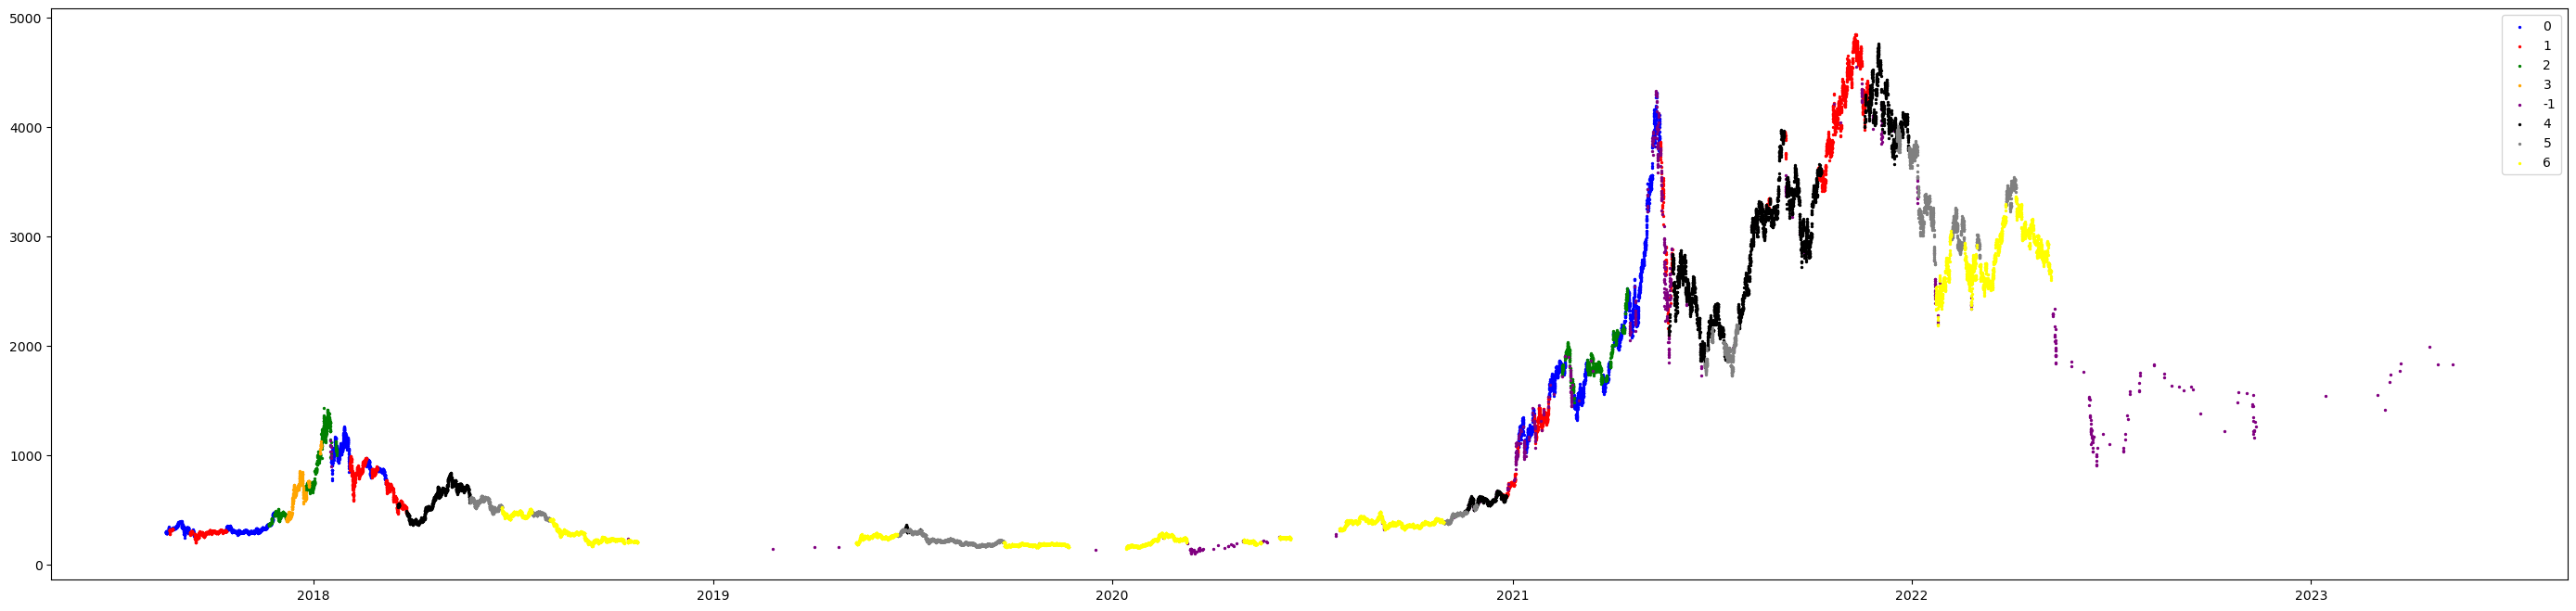

In [371]:
# Plot the time series with clusters in different colors
fig, ax = plt.subplots(figsize=(35, 8))
for label, color in zip(df_encoded['cluster'].unique(), ['blue', 'red', 'green', 'orange', 'purple','black','grey','yellow']): #,'magenta','cyan']):
    mask = df_encoded['cluster'] == label
    ax.scatter(df_encoded.index[mask], df_encoded['close'][mask], label=label, c=color, s=2)
ax.legend()
plt.show()

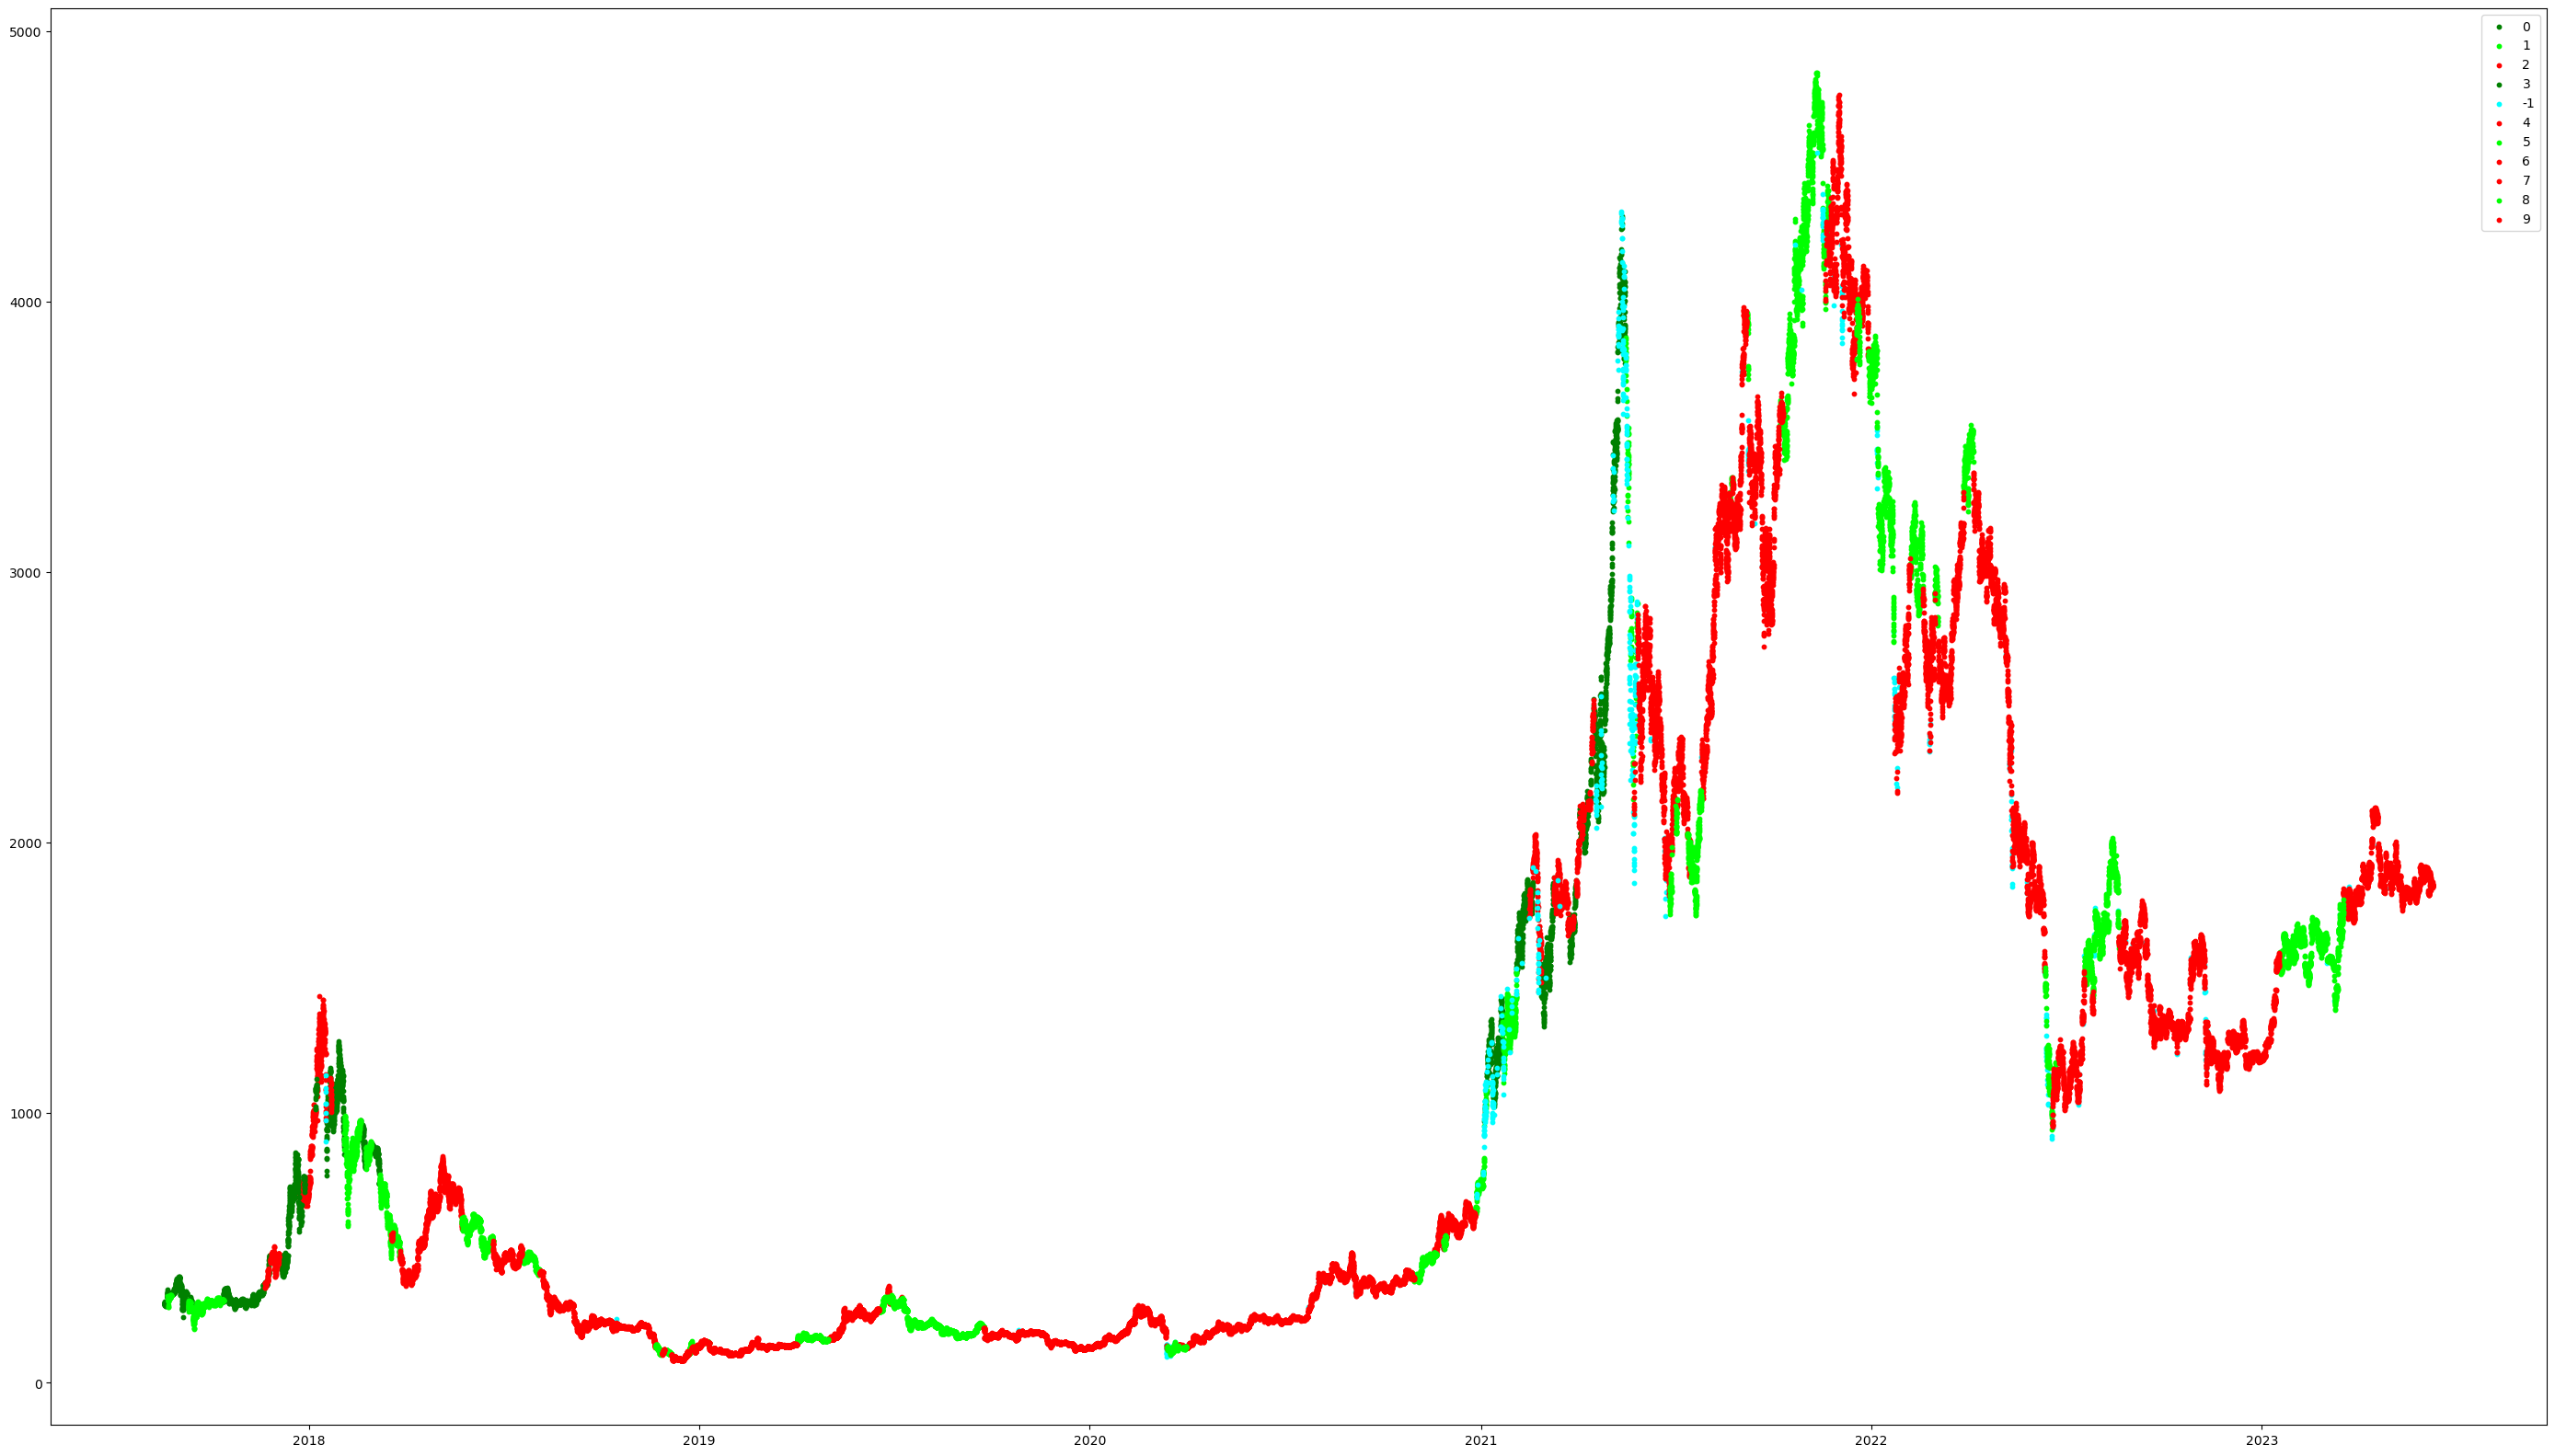

In [407]:
# Plot the time series with clusters in different colors
fig, ax = plt.subplots(figsize=(35, 20))
for label, color in zip(df_encoded['cluster'].unique(), ['green', 'lime', 'red', 'green', 'cyan','red','lime', 'red','red','lime', 'red']):
    mask = df_encoded['cluster'] == label
    ax.scatter(df_encoded.index[mask], df_encoded['close'][mask], label=label, c=color, s=10)
ax.legend()
plt.show()

In [408]:
# Display the plot inline in Jupyter Lab
%matplotlib inline

# Create the scatter plot using hvplot.scatter
scatter = df_encoded.hvplot.scatter(x='index', y='close', by='cluster', legend='top')

# Set the plot options
scatter.opts(
    title='Time Series with Clusters',
    xlabel='Date',
    ylabel='Close Price',
    height=500,
    width=1000
)

# Show the plot
hvplot.show(scatter)

Launching server at http://localhost:54692


In [409]:
df_eda  = df_encoded


In [410]:
df_eda [['fng_value','fng_classification','actual_returns']] = df_eng [['fng_value','fng_classification','actual_returns']]

In [411]:
df_eda.columns

Index(['volume', 'SMA_5', 'ADX_5', 'RSI_5', 'AO', 'fng_X-low', 'fng_very-low',
       'fng_low', 'fng_low-mid', 'fng_mid', 'fng_mid-high', 'fng_upper-mid',
       'fng_high', 'fng_very-high', 'fng_X-high', 'cluster', 'close',
       'actual_returns', 'fng_value', 'fng_classification', 'signal',
       'Position', 'Entry/Exit Position', 'Portfolio Holdings',
       'Portfolio Cash', 'Portfolio Total', 'Portfolio Daily Returns',
       'Portfolio Cumulative Returns'],
      dtype='object')

<Axes: xlabel='cluster', ylabel='fng_value'>

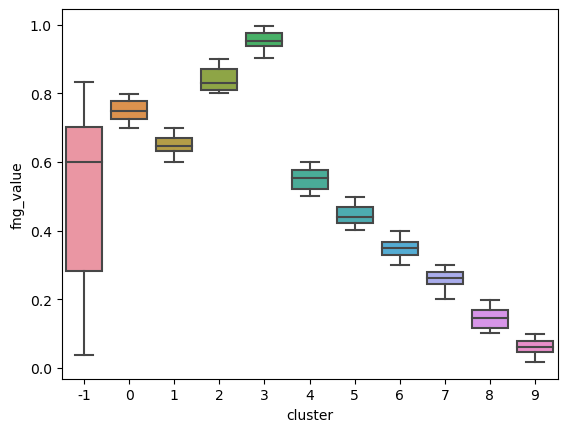

In [412]:
import seaborn as sns

# create a new DataFrame with just the relevant columns
cluster_df = df_eda[['cluster', 'fng_value', 'actual_returns']]

# create boxplots of fng_value and actual_returns for each cluster
sns.boxplot(data=cluster_df, x='cluster', y='fng_value')


<Axes: xlabel='cluster', ylabel='actual_returns'>

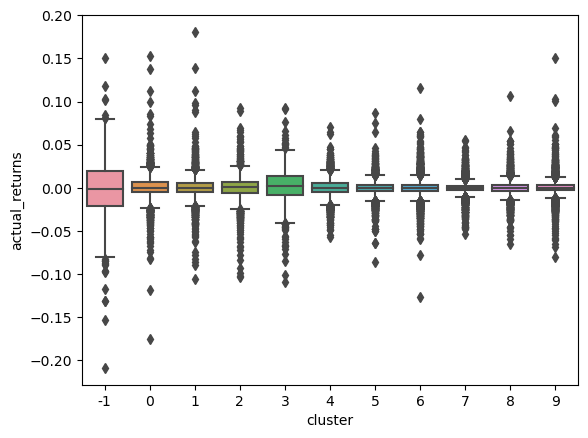

In [413]:
sns.boxplot(data=cluster_df, x='cluster', y='actual_returns')

In [414]:
# Replace cluster labels -1 and 3 with 1, and the rest with 0
df_eda['signal'] = np.where((df_eda['cluster']==-1) | (df_eda['cluster']==2)| (df_eda['cluster']==3 | (df_eda['cluster']==4)), 0, 1)


In [415]:
# Replace cluster labels -1 and 3 with 1, and the rest with 0
# df_eda['signal'] = np.where(((df_eda['cluster']==0)| (df_eda['cluster']==4 )| (df_eda['cluster']==3)), 1, 0)

> keeping previous code : # Replace cluster labels -1 and 3 with 1, and the rest with 0
> df_eda['signal'] = np.where((df_eda['cluster']==-1) | (df_eda['cluster']==2)| (df_eda['cluster']==3 | (df_eda['cluster']==0)), 0, 1)

In [416]:
df_eda['signal'].unique()

array([1, 0])

In [417]:
df_eda['signal'].value_counts()

signal
1    44997
0     5789
Name: count, dtype: int64

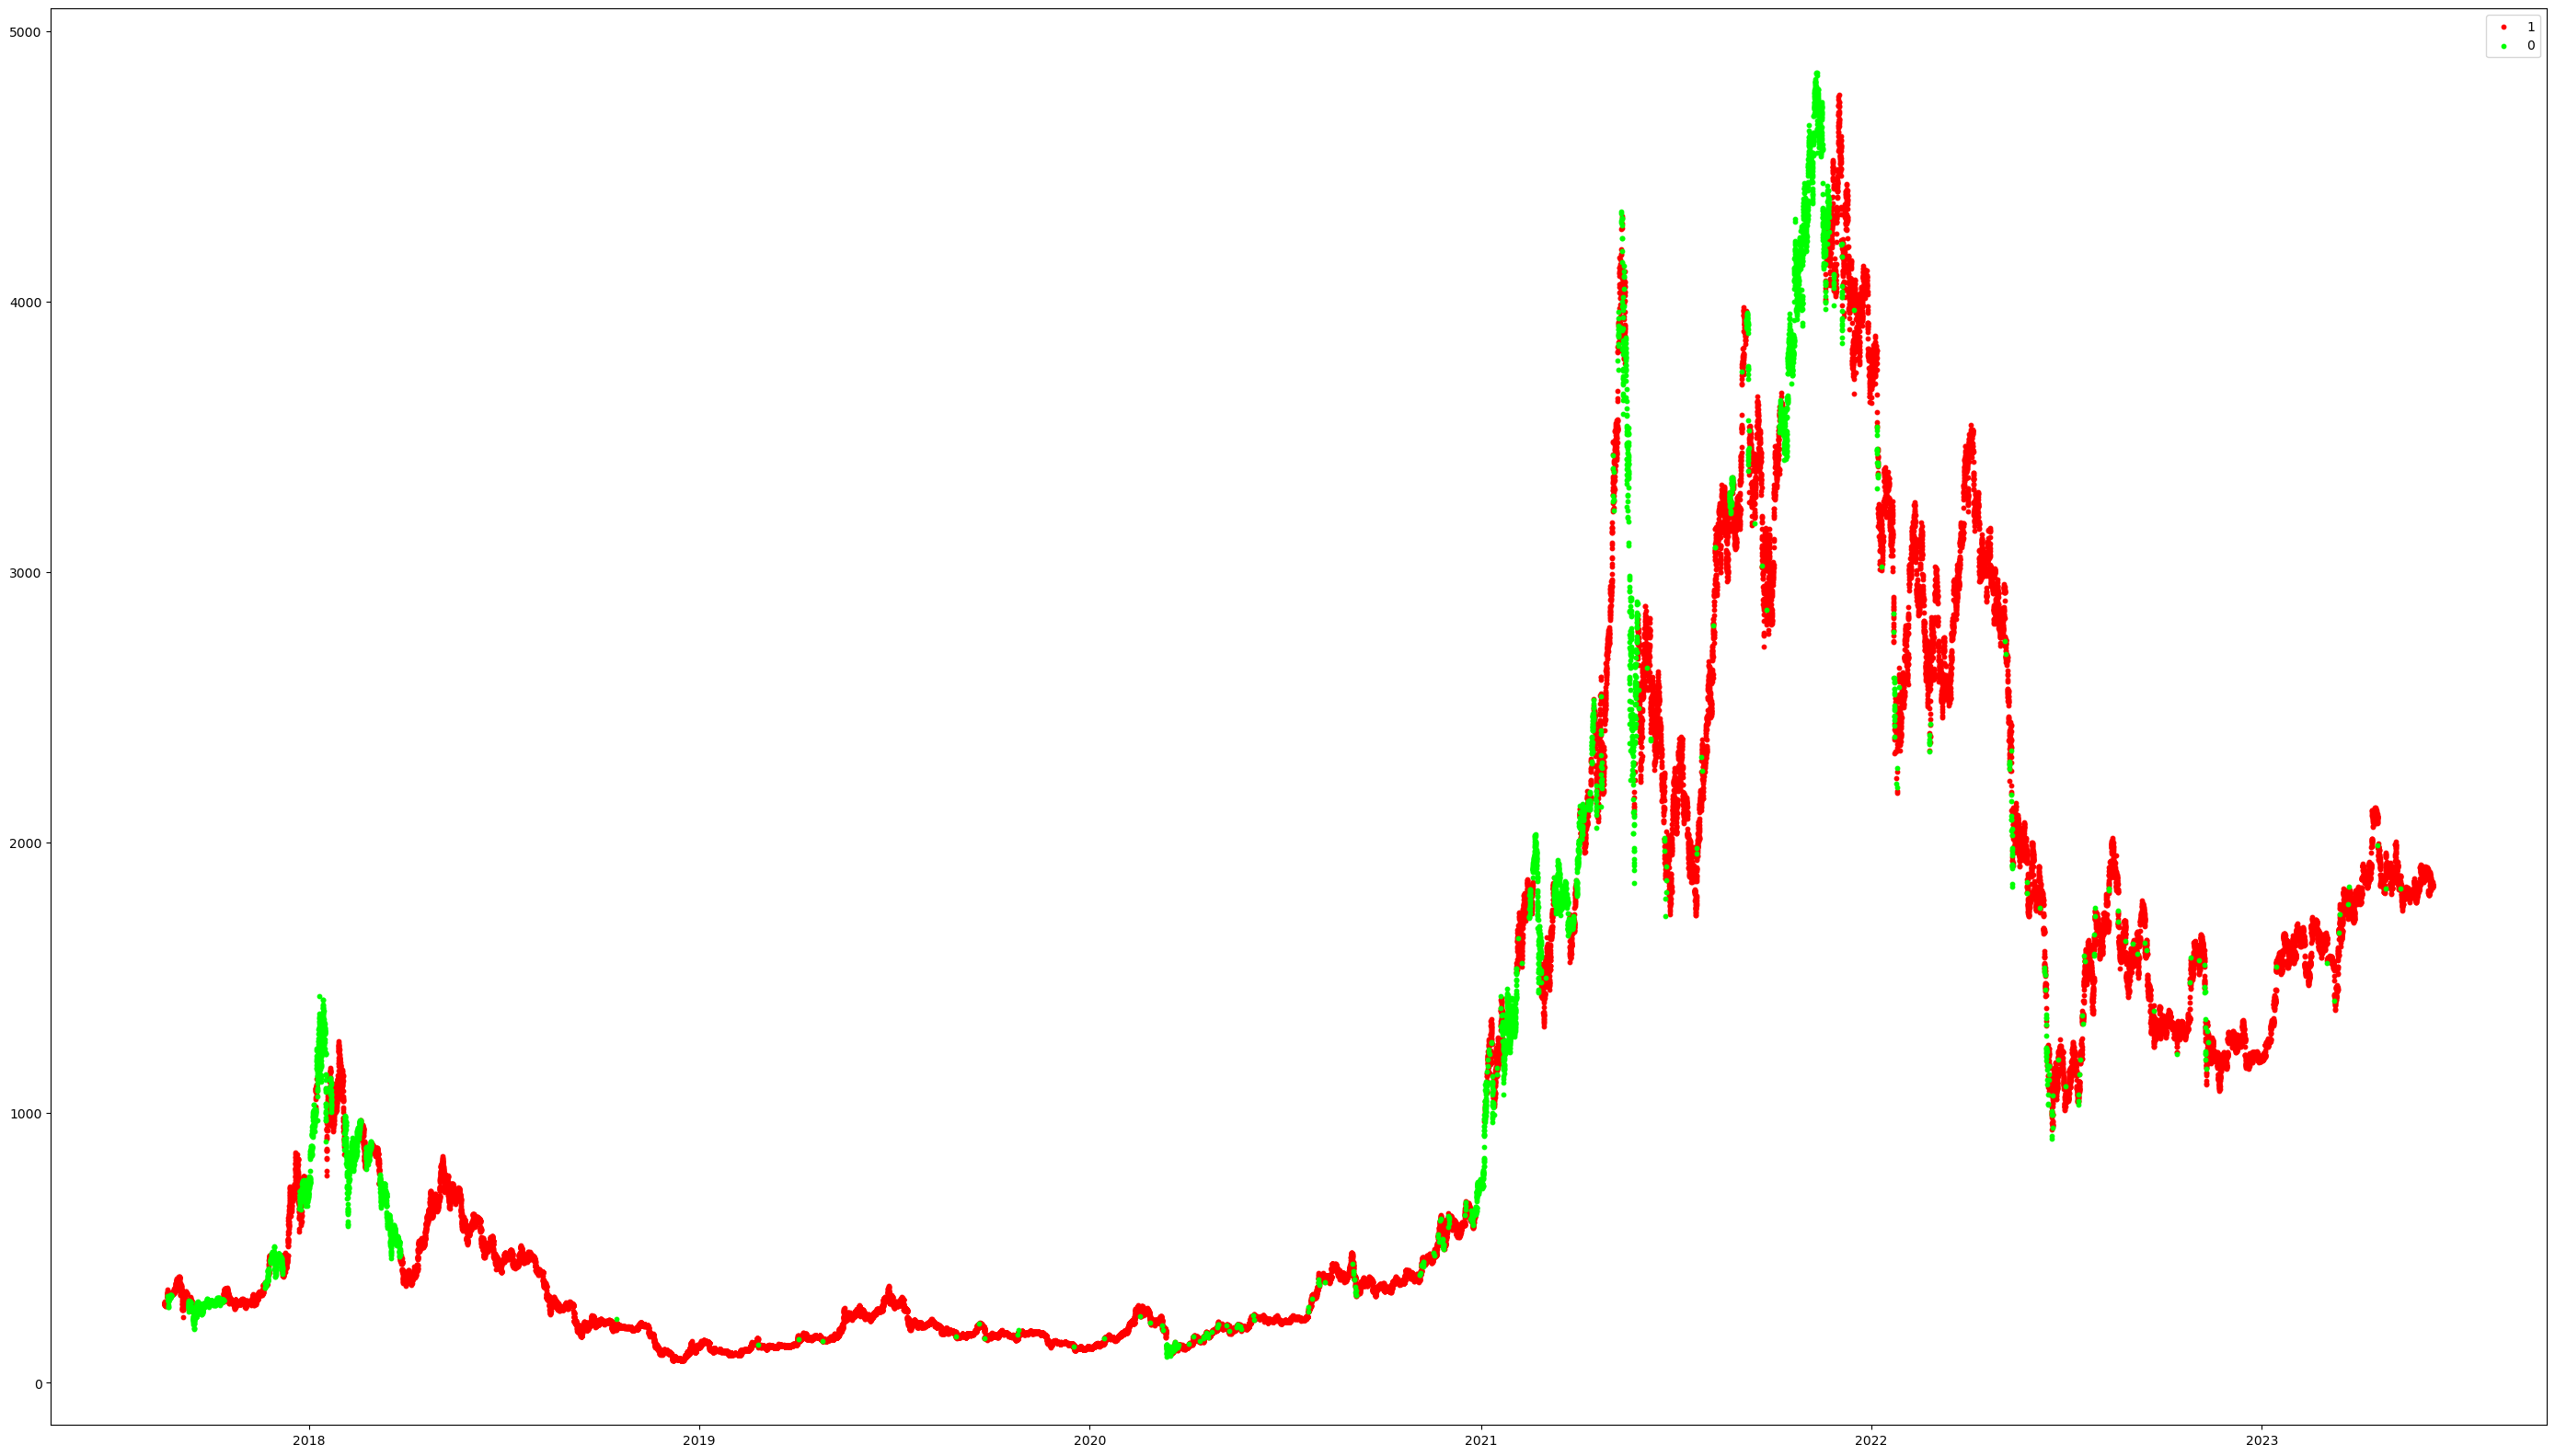

In [418]:
# Plot the time series with clusters in different colors
fig, ax = plt.subplots(figsize=(35, 20))
for label, color in zip(df_eda['signal'].unique(), ['red','lime']):
    mask = df_eda['signal'] == label
    ax.scatter(df_eda.index[mask], df_eda['close'][mask], label=label, c=color, s=10)
ax.legend()
plt.show()

In [419]:
# Display the plot inline in Jupyter Lab
%matplotlib inline

# Plot the time series with clusters in different colors
plot = df_encoded.hvplot.scatter(x='index', y='close',  c='cluster', legend='top_left', height=500, width=1000, title='Clusters of Time Series')

# Show the plot in Jupyter notebook
plot

:Scatter   [index]   (close,cluster)

In [420]:
# Set initial capital
initial_capital = float(100000)

# Set the share size
share_size = 500

# Buy a 500 share position when the dual moving average crossover Signal equals 1
# Otherwise, `Position` should be zero (sell)
df_eda['Position'] = share_size * df_eda['signal']

# Determine the points in time where a 500 share position is bought or sold
df_eda['Entry/Exit Position'] = df_eda['Position'].diff()

# Multiply the close price by the number of shares held, or the Position
df_eda['Portfolio Holdings'] = df_eda['close'] * df_eda['Position']

# Subtract the amount of either the cost or proceeds of the trade from the initial capital invested
df_eda['Portfolio Cash'] = initial_capital - (df_eda['close'] * df_eda['Entry/Exit Position']).cumsum() 

# Calculate the total portfolio value by adding the portfolio cash to the portfolio holdings (or investments)
df_eda['Portfolio Total'] = df_eda['Portfolio Cash'] + df_eda['Portfolio Holdings']

# Calculate the portfolio daily returns
df_eda['Portfolio Daily Returns'] = df_eda['Portfolio Total'].pct_change()

# Calculate the portfolio cumulative returns
df_eda['Portfolio Cumulative Returns'] = (1 + df_eda['Portfolio Daily Returns']).cumprod() - 1



In [421]:
# Visualize the value of the total portfolio
total_portfolio_value = df_eda[['Portfolio Total']].hvplot(
    line_color='lightgray',
    ylabel='Total Portfolio Value',
    xlabel='Date',
    width=1000,
    height=400
)


In [422]:
total_portfolio_value

:Curve   [index]   (Portfolio Total)

In [423]:
df_eda.head()

volume    SMA_5      ADX_5      RSI_5        AO  \
2017-08-18 14:00:00  398.64644  305.374  36.760414  24.627587  0.387000   
2017-08-18 15:00:00  214.98578  303.358  39.408533  26.452440 -1.287912   
2017-08-18 16:00:00  403.96386  301.644  43.226735  29.573398 -3.277882   
2017-08-18 17:00:00  359.12225  299.056  48.177486  20.034888 -5.373676   
2017-08-18 18:00:00  412.39491  296.362  53.955933  12.266947 -7.243647   

                     fng_X-low  fng_very-low  fng_low  fng_low-mid  fng_mid  \
2017-08-18 14:00:00      False         False    False        False    False   
2017-08-18 15:00:00      False         False    False        False    False   
2017-08-18 16:00:00      False         False    False        False    False   
2017-08-18 17:00:00      False         False    False        False    False   
2017-08-18 18:00:00      False         False    False        False    False   

                     ...  fng_value  fng_classification  signal  Position  \
2017-08-18 14:00:00  ...     0.7223                high       1       500   
2017-08-18 15:00:00  ...     0.7223                high       1       500   
2017-08-18 16:00:00  ...     0.7223                high       1       500   
2017-08-18 17:00:00  ...     0.7223                high       1       500   
2017-08-18 18:00:00  ...     0.7223                high       1       500   

                     Entry/Exit Position  Portfolio Holdings  Portfolio Cash  \
2017-08-18 14:00:00                  NaN            149260.0             NaN   
2017-08-18 15:00:00                  0.0            149400.0        100000.0   
2017-08-18 16:00:00                  0.0            149605.0        100000.0   
2017-08-18 17:00:00                  0.0            147765.0        100000.0   
2017-08-18 18:00:00                  0.0            144875.0        100000.0   

                     Portfolio Total  Portfolio Daily Returns  \
2017-08-18 14:00:00              NaN                      NaN   
2017-08-18 15:00:00         249400.0                      NaN   
2017-08-18 16:00:00         249605.0                 0.000822   
2017-08-18 17:00:00         247765.0                -0.007372   
2017-08-18 18:00:00         244875.0                -0.011664   

                    Portfolio Cumulative Returns  
2017-08-18 14:00:00                          NaN  
2017-08-18 15:00:00                          NaN  
2017-08-18 16:00:00                     0.000822  
2017-08-18 17:00:00                    -0.006556  
2017-08-18 18:00:00                    -0.018144  

[5 rows x 28 columns]

---
## 2ND Feat Engineering

In [424]:
import finta as ft
from finta import TA
import talib

prep_df = df_eng.copy()
prep_df['signal'] = df_eda['signal']


In [425]:
prep_df.columns

Index(['fng_value', 'fng_classification', 'open', 'high', 'low', 'close',
       'volume', 'actual_returns', 'SMA_5', 'EMA_5', 'HMA_5', 'VAMA_5',
       'ATR_5', 'ADX_5', 'RSI_5', 'SMA_7', 'EMA_7', 'HMA_7', 'VAMA_7', 'ATR_7',
       'ADX_7', 'RSI_7', 'SMA_14', 'EMA_14', 'HMA_14', 'VAMA_14', 'ATR_14',
       'ADX_14', 'RSI_14', 'SMA_20', 'EMA_20', 'HMA_20', 'VAMA_20', 'ATR_20',
       'ADX_20', 'RSI_20', 'SMA_30', 'EMA_30', 'HMA_30', 'VAMA_30', 'ATR_30',
       'ADX_30', 'RSI_30', 'SMA_50', 'EMA_50', 'HMA_50', 'VAMA_50', 'ATR_50',
       'ADX_50', 'RSI_50', 'SMA_70', 'EMA_70', 'HMA_70', 'VAMA_70', 'ATR_70',
       'ADX_70', 'RSI_70', 'SMA_100', 'EMA_100', 'HMA_100', 'VAMA_100',
       'ATR_100', 'ADX_100', 'RSI_100', 'SMA_150', 'EMA_150', 'HMA_150',
       'VAMA_150', 'ATR_150', 'ADX_150', 'RSI_150', 'SMA_200', 'EMA_200',
       'HMA_200', 'VAMA_200', 'ATR_200', 'ADX_200', 'RSI_200', 'UO', 'AO',
       'OBV', 'CHAIKIN', 'BB_UPPER', 'BB_MED', 'BB_LOWER', 'cci', 'tenkan_sen',
       'kiju

In [426]:
# Dummy-encoding process 
# create a list of categorical columns
cat_cols = ['fng_classification']

# use the get_dummies function to dummy encode the categorical columns
dummy_cols = pd.get_dummies(prep_df[cat_cols], prefix=cat_cols, drop_first=True)

# concatenate the dummy columns with the original dataframe
prep_df = pd.concat([prep_df.drop(cat_cols, axis=1), dummy_cols], axis=1)

In [427]:
prep_df['signal'].value_counts()

signal
1.0    44997
0.0     5789
Name: count, dtype: int64

___
### 3.5 Class Imbalance

In [428]:
import pandas as pd
from sklearn.utils import resample

# Count the number of samples in each class
class_counts = prep_df['signal'].value_counts()

# Find the class with fewer samples
minority_class = class_counts.idxmin()

# Split the dataframe into the majority and minority classes
majority_class = prep_df[prep_df['signal'] != minority_class]
minority_class = prep_df[prep_df['signal'] == minority_class]

# Undersample the majority class to match the number of samples in the minority class
undersampled_majority = resample(majority_class,
                                 replace=False,
                                 n_samples=len(minority_class),
                                 random_state=42)

# Combine the undersampled majority class with the minority class
balanced_df = pd.concat([undersampled_majority, minority_class])

# Shuffle the rows in the balanced dataframe
balanced_df = balanced_df.sample(frac=1, random_state=42)

In [429]:
balanced_df["signal"].value_counts()

signal
0.0    5789
1.0    5786
Name: count, dtype: int64

In [430]:
# Creating X as predictors (features) dataset
X= balanced_df.copy()

# sort X by index
X = X.sort_index(axis=0)

# Removing columns indicative of previous prices
# & shifting X one row down to avoid using data not available to us at the time of prediction
X= X.drop(["open","high","low","close","volume","actual_returns","signal"], axis =1).shift().dropna().copy()

In [431]:
X

fng_value     SMA_5        EMA_5        HMA_5  \
2017-09-02 23:00:00     0.7414   335.940   335.034586   328.105556   
2017-09-03 14:00:00     0.7414   331.734   334.920618   338.516000   
2017-09-04 06:00:00     0.7303   334.334   333.765044   322.458000   
2017-09-04 20:00:00     0.7314   332.670   333.539649   334.644000   
2017-09-05 06:00:00     0.7314   286.636   291.462750   306.645333   
...                        ...       ...          ...          ...   
2023-06-07 20:00:00     0.2501  1861.896  1865.554032  1866.786222   
2023-06-08 07:00:00     0.2501  1846.350  1846.821443  1845.706667   
2023-06-08 16:00:00     0.2511  1838.508  1839.308406  1842.159778   
2023-06-08 18:00:00     0.2511  1850.228  1849.285154  1851.600444   
2023-06-09 13:00:00     0.2511  1849.738  1847.025624  1842.248444   

                          VAMA_5   ATR_5      ADX_5      RSI_5        SMA_7  \
2017-09-02 23:00:00   334.957058  10.518  79.661445  20.476812   336.677143   
2017-09-03 14:00:00   331.607894  11.982  60.038337  60.983606   334.227143   
2017-09-04 06:00:00   332.885729  14.246  46.729172  23.553102   338.810000   
2017-09-04 20:00:00   332.816562   8.480  30.444296  43.978877   333.155714   
2017-09-05 06:00:00   286.842436  10.670  54.465958  65.524652   282.817143   
...                          ...     ...        ...        ...          ...   
2023-06-07 20:00:00  1859.034668  16.904  35.656428  43.800540  1865.605714   
2023-06-08 07:00:00  1846.178638   9.716  42.215455  31.125946  1845.012857   
2023-06-08 16:00:00  1838.558667   7.662  31.014850  61.635673  1838.361429   
2023-06-08 18:00:00  1849.553632  13.552  39.923042  45.655418  1848.530000   
2023-06-09 13:00:00  1851.678015  10.458  32.023017  48.903094  1848.724286   

                           EMA_7  ...  chikou_span  \
2017-09-02 23:00:00   337.667621  ...       341.38   
2017-09-03 14:00:00   335.623528  ...       335.65   
2017-09-04 06:00:00   336.639561  ...       273.48   
2017-09-04 20:00:00   334.110192  ...       288.00   
2017-09-05 06:00:00   290.218622  ...       315.53   
...                          ...  ...          ...   
2023-06-07 20:00:00  1866.594381  ...      1855.66   
2023-06-08 07:00:00  1848.435118  ...      1849.47   
2023-06-08 16:00:00  1838.894570  ...      1844.27   
2023-06-08 18:00:00  1848.322845  ...      1838.06   
2023-06-09 13:00:00  1846.932850  ...      1837.10   

                     fng_classification_very-low  fng_classification_low  \
2017-09-02 23:00:00                        False                   False   
2017-09-03 14:00:00                        False                   False   
2017-09-04 06:00:00                        False                   False   
2017-09-04 20:00:00                        False                   False   
2017-09-05 06:00:00                        False                   False   
...                                          ...                     ...   
2023-06-07 20:00:00                        False                    True   
2023-06-08 07:00:00                        False                    True   
2023-06-08 16:00:00                        False                    True   
2023-06-08 18:00:00                        False                    True   
2023-06-09 13:00:00                        False                    True   

                     fng_classification_low-mid  fng_classification_mid  \
2017-09-02 23:00:00                       False                   False   
2017-09-03 14:00:00                       False                   False   
2017-09-04 06:00:00                       False                   False   
2017-09-04 20:00:00                       False                   False   
2017-09-05 06:00:00                       False                   False   
...                                         ...                     ...   
2023-06-07 20:00:00                       False                   False   
2023-06-08 07:00:00                       False                   Fal

In [432]:
# Copy the new signal column to a new Series called y.
y = balanced_df["signal"].copy()

# keeping y and X the same size 
y = y[X.index]

In [433]:
y

2017-09-02 23:00:00    1.0
2017-09-03 14:00:00    1.0
2017-09-04 06:00:00    1.0
2017-09-04 20:00:00    1.0
2017-09-05 06:00:00    1.0
                      ... 
2023-06-07 20:00:00    1.0
2023-06-08 07:00:00    1.0
2023-06-08 16:00:00    1.0
2023-06-08 18:00:00    1.0
2023-06-09 13:00:00    1.0
Name: signal, Length: 11451, dtype: float64

---
## ML Scaler

In [434]:
from sklearn.preprocessing import StandardScaler

# Scale the data
MLscaler = StandardScaler()
X_scaled = MLscaler.fit_transform(X)

# Convert the scaled numpy array back to a pandas DataFrame
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

In [435]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Scale the data
X_scaled = scaler.fit_transform(X)

# Convert X_scaled back to a DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Create a logistic regression model
model = LogisticRegression(max_iter=200)

# Create an RFE model to select the best features
rfe = RFE(model, n_features_to_select=25)

# Fit the RFE model to the data
rfe = rfe.fit(X_scaled, y)

# Get the selected features
selected_features = X_scaled.columns[rfe.support_]

# Keep only specified columns in the dataframe
X_scaled = X_scaled[selected_features]

# Print the selected features
print("Number of selected features:", len(X_scaled.columns), "\nSelected features:\n", selected_features)


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

Number of selected features: 25 
Selected features:
 Index(['ADX_5', 'ATR_7', 'VAMA_14', 'ATR_14', 'ATR_20', 'HMA_30', 'HMA_50',
       'RSI_50', 'VAMA_100', 'RSI_100', 'ATR_150', 'RSI_150', 'SMA_200',
       'EMA_200', 'ATR_200', 'RSI_200', 'OBV', 'BB_UPPER', 'BB_LOWER',
       'kijun_sen', 'senkou_span_a', 'senkou_span_b', 'chikou_span',
       'fng_classification_upper-mid', 'fng_classification_very-high'],
      dtype='object')


In [436]:
df_lo_feats = X[selected_features].copy()
#df_lo_feats = df_lo_feats.drop(["fng_value"], axis =1)
# Calculate correlation matrix
# calculate the correlation matrix of the features
corr_matrix = df_lo_feats.corr()

# set the threshold for correlation value
corr_threshold = 0.90

# find the highly correlated features and drop them from the dataframe
high_corr_features = np.where(corr_matrix.abs() > corr_threshold)
high_corr_features = [(corr_matrix.columns[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_features) if x != y and x < y]
df_lo_feats.drop([col[1] for col in high_corr_features], axis=1, inplace=True)

# select the remaining features with low correlation
low_corr_features = df_lo_feats.columns.tolist()

# print the low correlated features
print(low_corr_features)

['ADX_5', 'ATR_7', 'VAMA_14', 'RSI_50', 'fng_classification_upper-mid', 'fng_classification_very-high']


In [437]:
X=df_lo_feats[low_corr_features]
#X = X[selected_features]

In [438]:
# Imports 
from pandas.tseries.offsets import DateOffset

# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
#print(training_begin)

# Select the ending period for the training data with an offset of 36 months
training_end = X.index.min() + DateOffset(months=36)

# Display the training end date
#print(training_end)

# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Display sample data
display(X_train.head())

# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

# Display sample data
display(X_test.head())

ADX_5      ATR_7     VAMA_14     RSI_50  \
2017-09-02 23:00:00  79.661445  13.445714  346.670824  38.415716   
2017-09-03 14:00:00  60.038337  11.435714  341.850084  44.016141   
2017-09-04 06:00:00  46.729172  13.594286  343.578954  41.519486   
2017-09-04 20:00:00  30.444296   8.448571  335.706716  44.546991   
2017-09-05 06:00:00  54.465958  11.984286  289.543707  44.155573   

                    fng_classification_upper-mid fng_classification_very-high  
2017-09-02 23:00:00                        False                        False  
2017-09-03 14:00:00                        False                        False  
2017-09-04 06:00:00                        False                        False  
2017-09-04 20:00:00                        False                        False  
2017-09-05 06:00:00                        False                        False

ADX_5      ATR_7     VAMA_14     RSI_50  \
2020-09-03 07:00:00  68.295512   9.727143  445.430180  48.717705   
2020-09-03 12:00:00  40.308234   9.018571  437.393913  49.175864   
2020-09-03 15:00:00  53.722102  11.402857  430.018254  42.735091   
2020-09-03 23:00:00  69.242897  14.167143  424.395532  41.203012   
2020-09-04 02:00:00  71.247751  11.600000  406.509705  38.224289   

                    fng_classification_upper-mid fng_classification_very-high  
2020-09-03 07:00:00                        False                        False  
2020-09-03 12:00:00                        False                        False  
2020-09-03 15:00:00                        False                        False  
2020-09-03 23:00:00                        False                        False  
2020-09-04 02:00:00                        False                        False

In [439]:
## Scaler for ML pre-processing

In [440]:
# Create a StandardScaler instance
scaler = StandardScaler()
 
# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)
 
# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

---
## 4. ML models 
#### 4.1 XGboost

In [441]:
import xgboost as xgb
#from xgboost import xgbClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV

#replace -1 by 0 as xgboost expects a boolean target vector (only 0 and 1)
y_train = y_train.replace(-1, 0)
y_test = y_test.replace(-1, 0)

# Create a xgb Classifier model
xgb_clf = xgb.XGBClassifier(reg_alpha=1)

xgb_clf.fit(X_train_scaled, y_train) 

# Use the best model to make predictions on the test data
y_pred_xgb = xgb_clf.predict(X_test_scaled)

ROC(xgb_clf,X_train,X_test,y_train,y_test)

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:fng_classification_upper-mid: object, fng_classification_very-high: object

<Axes: >

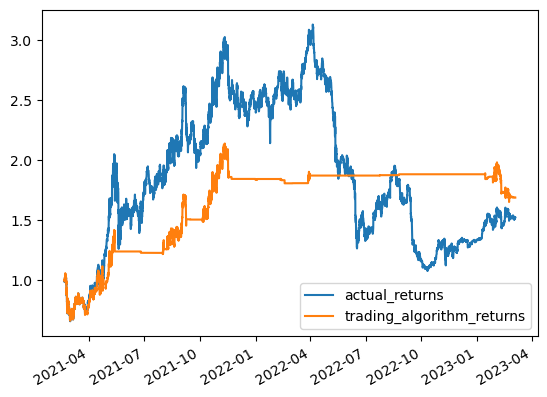

In [ ]:
# Define the trading fee as a decimal
trading_fee = 0.00075
classifier = xgb_clf

# Backtest using our exteranl function
xgb_predictions_df = Backtesting (prep_df, X_test, X_test_scaled, classifier,trading_fee)

# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + xgb_predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

> The XGB results appear to be too good to be true - the classification report are very weird as well --> not to use for production

In [ ]:
X_test.columns


Index(['fng_value', 'ATR_5', 'ADX_7', 'VAMA_14', 'ADX_14', 'RSI_14', 'RSI_50',
       'ADX_70', 'fng_classification_Extreme Greed', 'fng_classification_Fear',
       'fng_classification_Greed'],
      dtype='object')

---
#### 4.2 CatBoost

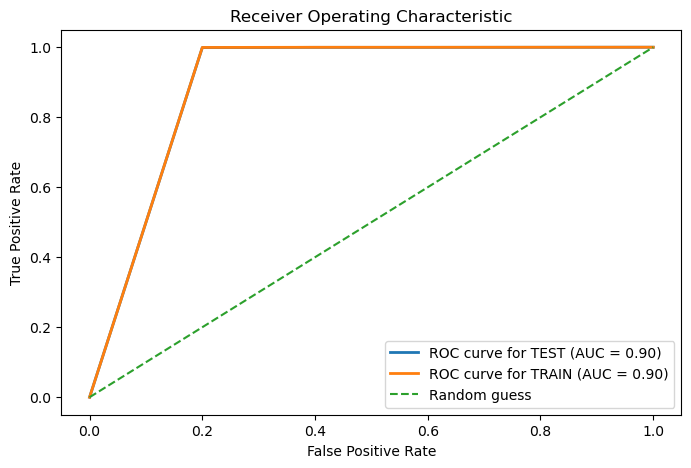

TRAINING classification report: 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7245
         1.0       1.00      1.00      1.00     10762

    accuracy                           1.00     18007
   macro avg       1.00      1.00      1.00     18007
weighted avg       1.00      1.00      1.00     18007


TESTING classification report: 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8747
         1.0       1.00      1.00      1.00      5428

    accuracy                           1.00     14175
   macro avg       1.00      1.00      1.00     14175
weighted avg       1.00      1.00      1.00     14175

Test accuracy: 1.00
>> Test precision: 1.00 <<
Test recall: 1.00
Test F1 score: 1.00
Test AUC score: 0.90


In [ ]:
# Import libraries
from catboost import CatBoostClassifier
# Initialize the CatBoost model

cb_clf = CatBoostClassifier(
    iterations=300,
    learning_rate=0.005,
    #depth=5,
    l2_leaf_reg=500,  # L2 regularization parameter
    verbose=False
)

# Train the model on the training data
cb_clf.fit(X_train_scaled, y_train)

# display ROC and classification metrics 
ROC(cb_clf,X_train_scaled, X_test_scaled, y_train, y_test)


<Axes: >

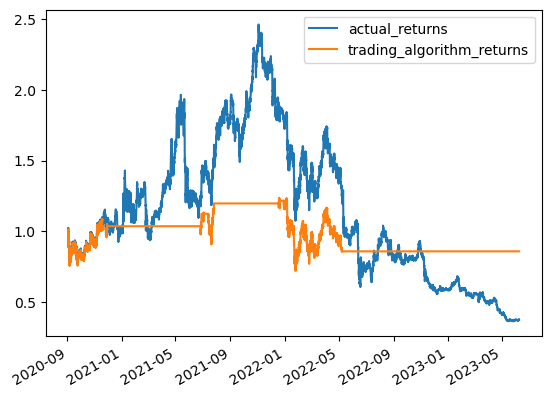

In [ ]:
# Define the trading fee as a decimal
trading_fee = 0.00075
classifier = cb_clf

# Backtest using our exteranl function
cb_predictions_df = Backtesting (df_eda, X_test, X_test_scaled, classifier,trading_fee)

# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + cb_predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

---
#### 4.3 LDA

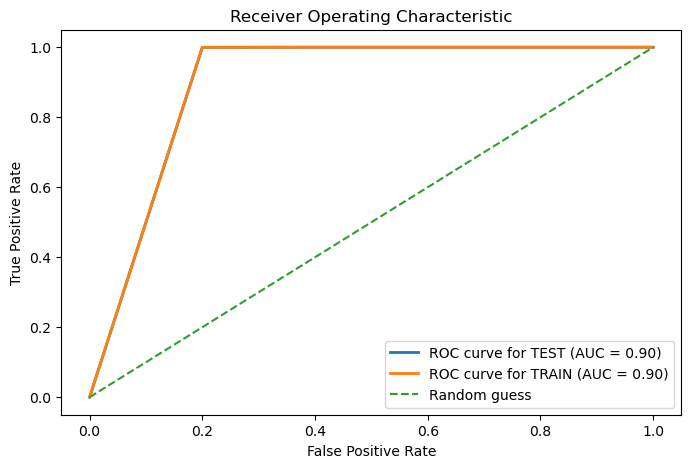

TRAINING classification report: 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7245
         1.0       1.00      1.00      1.00     10762

    accuracy                           1.00     18007
   macro avg       1.00      1.00      1.00     18007
weighted avg       1.00      1.00      1.00     18007


TESTING classification report: 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8747
         1.0       1.00      1.00      1.00      5428

    accuracy                           1.00     14175
   macro avg       1.00      1.00      1.00     14175
weighted avg       1.00      1.00      1.00     14175

Test accuracy: 1.00
>> Test precision: 1.00 <<
Test recall: 1.00
Test F1 score: 1.00
Test AUC score: 0.90


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# create LDA object and fit the model
lda = LinearDiscriminantAnalysis()

# Train the model on the training data
lda.fit_transform(X_train_scaled, y_train)

ROC(lda,X_train_scaled, X_test_scaled, y_train, y_test)

<Axes: >

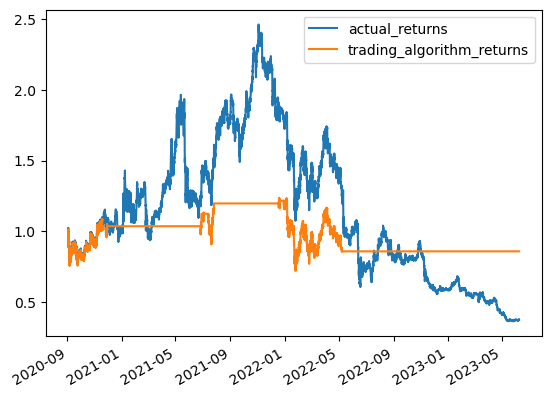

In [ ]:
# Define the trading fee as a decimal
trading_fee = 0.00075
classifier = lda

# Backtest using our exteranl function
lda_predictions_df = Backtesting (prep_df, X_test, X_test_scaled, classifier,trading_fee)

# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + lda_predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

## 4.4 Gradient Boosting Tree Classifier

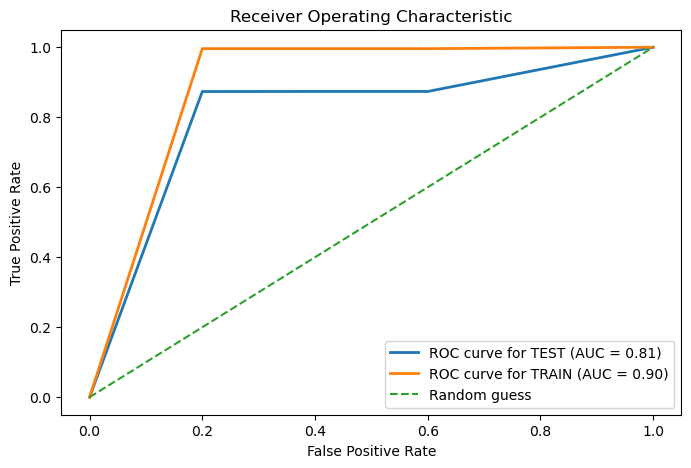

TRAINING classification report: 
               precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      7245
         1.0       1.00      1.00      1.00     10762

    accuracy                           1.00     18007
   macro avg       1.00      1.00      1.00     18007
weighted avg       1.00      1.00      1.00     18007


TESTING classification report: 
               precision    recall  f1-score   support

         0.0       0.92      0.95      0.94      8747
         1.0       0.92      0.87      0.90      5428

    accuracy                           0.92     14175
   macro avg       0.92      0.91      0.92     14175
weighted avg       0.92      0.92      0.92     14175

Test accuracy: 0.92
>> Test precision: 0.92 <<
Test recall: 0.92
Test F1 score: 0.92
Test AUC score: 0.81


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Initialize the model with regularization
gbt_clf = GradientBoostingClassifier(learning_rate = 0.45, subsample = 0.5, 
                                     max_depth=5, min_samples_split=4, 
                                     min_samples_leaf=2, max_leaf_nodes=None, random_state=seed)

# Train the model on the training data
gbt_clf.fit(X_train_scaled, y_train)

ROC(gbt_clf,X_train_scaled, X_test_scaled, y_train, y_test)


<Axes: >

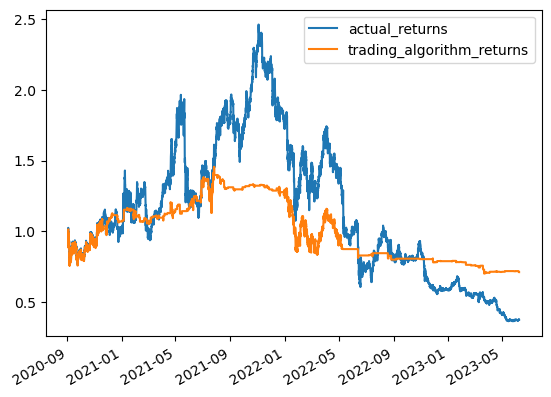

In [ ]:
# Define the trading fee as a decimal
trading_fee = 0.00075
classifier = gbt_clf

# Backtest using our exteranl function
gbt_predictions_df = Backtesting (prep_df, X_test, X_test_scaled, classifier,trading_fee)

# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + gbt_predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

In [ ]:
display (df_eda.head())
display (gbt_predictions_df.head())

volume       ADX_5  fng_Fear  fng_Greed  \
2018-02-01 05:00:00   3462.28586  100.000000         1          0   
2018-02-01 06:00:00   3400.69303   50.133579         1          0   
2018-02-01 07:00:00   2589.27888   39.437213         1          0   
2018-02-01 08:00:00  12753.77711   53.920963         1          0   
2018-02-01 09:00:00   8388.78259   62.331328         1          0   

                     fng_Hi_Fear  fng_Hi_Greed  fng_Neutral  cluster    close  \
2018-02-01 05:00:00            0             0            0        0  1159.13   
2018-02-01 06:00:00            0             0            0        0  1142.99   
2018-02-01 07:00:00            0             0            0        0  1137.10   
2018-02-01 08:00:00            0             0            0        0  1123.30   
2018-02-01 09:00:00            0             0            0        0  1101.74   

                     actual_returns  fng_value fng_classification  signal  \
2018-02-01 05:00:00        0.005744         30               Fear       0   
2018-02-01 06:00:00       -0.013924         30               Fear       0   
2018-02-01 07:00:00       -0.005153         30               Fear       0   
2018-02-01 08:00:00       -0.012136         30               Fear       0   
2018-02-01 09:00:00       -0.019193         30               Fear       0   

                     Position  Entry/Exit Position  Portfolio Holdings  \
2018-02-01 05:00:00         0                  NaN                 0.0   
2018-02-01 06:00:00         0                  0.0                 0.0   
2018-02-01 07:00:00         0                  0.0                 0.0   
2018-02-01 08:00:00         0                  0.0                 0.0   
2018-02-01 09:00:00         0                  0.0                 0.0   

                     Portfolio Cash  Portfolio Total  Portfolio Daily Returns  \
2018-02-01 05:00:00             NaN              NaN                      NaN   
2018-02-01 06:00:00        100000.0         100000.0                      NaN   
2018-02-01 07:00:00        100000.0         100000.0                      0.0   
2018-02-01 08:00:00        100000.0         100000.0                      0.0   
2018-02-01 09:00:00        100000.0         100000.0                      0.0   

                     Portfolio Cumulative Returns  
2018-02-01 05:00:00                           NaN  
2018-02-01 06:00:00                           NaN  
2018-02-01 07:00:00                           0.0  
2018-02-01 08:00:00                           0.0  
2018-02-01 09:00:00                           0.0

predicted_signal  actual_returns  \
2021-02-19 00:00:00               1.0       -0.005769   
2021-02-19 01:00:00               1.0       -0.005963   
2021-02-19 02:00:00               1.0       -0.000209   
2021-02-19 03:00:00               1.0       -0.003292   
2021-02-19 04:00:00               1.0       -0.003638   

                     trading_algorithm_returns  
2021-02-19 00:00:00                        NaN  
2021-02-19 01:00:00                  -0.005963  
2021-02-19 02:00:00                  -0.000209  
2021-02-19 03:00:00                  -0.003292  
2021-02-19 04:00:00                  -0.003638

In [ ]:
display(len(df_eda),len(gbt_predictions_df))

44492

9297

In [ ]:
df = gbt_predictions_df

In [ ]:
df['close'] = df_eda['close']

In [ ]:
# Rename column 'predicted_signal' to 'gbt_prediction'
df = df.rename(columns={'predicted_signal': 'gbt_prediction'})

In [ ]:
df.head()

gbt_prediction  actual_returns  \
2021-02-19 00:00:00             1.0       -0.005769   
2021-02-19 01:00:00             1.0       -0.005963   
2021-02-19 02:00:00             1.0       -0.000209   
2021-02-19 03:00:00             1.0       -0.003292   
2021-02-19 04:00:00             1.0       -0.003638   

                     trading_algorithm_returns    close  
2021-02-19 00:00:00                        NaN  1928.42  
2021-02-19 01:00:00                  -0.005963  1916.92  
2021-02-19 02:00:00                  -0.000209  1916.52  
2021-02-19 03:00:00                  -0.003292  1910.21  
2021-02-19 04:00:00                  -0.003638  1903.26

In [ ]:
import pandas as pd
import numpy as np
import hvplot.pandas

# Assuming df is already loaded with 'close' and 'gbt_prediction' columns
initial_capital = 10000
duration_dca_buy = 3
duration_dca_sell = 1

# Add new columns to store calculations
df['eth_owned'] = 0.0
df['current_usd_capital'] = initial_capital
df['algo_value'] = 0.0
df['dca_value'] = 0.0

# Initialize the remaining buy and sell duration
remaining_buy_duration = duration_dca_buy
remaining_sell_duration = 0

# Loop through each row in the dataset
for i in range(1, len(df)):
    eth_owned = df.loc[df.index[i - 1], 'eth_owned']
    current_usd_capital = df.loc[df.index[i - 1], 'current_usd_capital']
    
    if df.loc[df.index[i], 'gbt_prediction'] == 1:
        if remaining_buy_duration > 0:
            # Calculate the daily_buy_amount based on the remaining buy duration
            daily_buy_amount = current_usd_capital / remaining_buy_duration
            remaining_buy_duration -= 1
        else:
            daily_buy_amount = 0

        # Buy using dollar-cost averaging
        if df.loc[df.index[i], 'close'] > 0:
            eth_to_buy = daily_buy_amount / df.loc[df.index[i], 'close']
            eth_owned += eth_to_buy
            current_usd_capital -= daily_buy_amount
        
            # Update daily_sell_amount
            daily_sell_amount = (eth_owned * df.loc[df.index[i], 'close']) / duration_dca_sell
        
    elif df.loc[df.index[i], 'gbt_prediction'] == 0 and eth_owned > 0:
        # Reset remaining_buy_duration
        remaining_buy_duration = duration_dca_buy
        
        # Sell using dollar-cost averaging
        if df.loc[df.index[i], 'close'] > 0:
            eth_to_sell = daily_sell_amount / df.loc[df.index[i], 'close']
            eth_owned -= eth_to_sell
            current_usd_capital += daily_sell_amount

    df.loc[df.index[i], 'eth_owned'] = eth_owned
    df.loc[df.index[i], 'current_usd_capital'] = current_usd_capital
    df.loc[df.index[i], 'algo_value'] = eth_owned * df.loc[df.index[i], 'close'] + current_usd_capital
    
    # Update DCA value
    if df.loc[df.index[i], 'close'] > 0:
        dca_eth_to_buy = daily_buy_amount / df.loc[df.index[i], 'close']
        df.loc[df.index[i], 'dca_value'] = df.loc[df.index[i - 1], 'dca_value'] + (dca_eth_to_buy * df.loc[df.index[i], 'close'])

In [ ]:


# Plot the results
plot = df[['algo_value']].hvplot.line(title='Algo-Trading Strategy vs. DCA', width=1000, height=400)
plot


:Curve   [index]   (algo_value)

In [ ]:
import pandas as pd
import numpy as np
import hvplot.pandas

# Assuming df is already loaded with 'close' and 'gbt_prediction' columns
initial_capital = 10000
duration_dca_buy = 4
duration_dca_sell = 1

# Add new columns to store calculations
df['eth_owned'] = 0.0
df['current_usd_capital'] = initial_capital
df['algo_value'] = 0.0
df['dca_value'] = 0.0
df['dca_eth_owned'] = 0.0

# Initialize the remaining buy and sell duration
remaining_buy_duration = duration_dca_buy
remaining_sell_duration = 0

# Calculate the daily_buy_amount for DCA strategy
daily_dca_buy_amount = initial_capital / duration_dca_buy

# Loop through each row in the dataset
for i in range(1, len(df)):
    eth_owned = df.loc[df.index[i - 1], 'eth_owned']
    current_usd_capital = df.loc[df.index[i - 1], 'current_usd_capital']
    dca_eth_owned = df.loc[df.index[i - 1], 'dca_eth_owned']
    
    if df.loc[df.index[i], 'gbt_prediction'] == 1:
        if remaining_buy_duration > 0:
            # Calculate the daily_buy_amount based on the remaining buy duration
            daily_buy_amount = current_usd_capital / remaining_buy_duration
            remaining_buy_duration -= 1
        else:
            daily_buy_amount = 0

        # Buy using dollar-cost averaging
        if df.loc[df.index[i], 'close'] > 0:
            eth_to_buy = daily_buy_amount / df.loc[df.index[i], 'close']
            eth_owned += eth_to_buy
            current_usd_capital -= daily_buy_amount
        
            # Update daily_sell_amount
            daily_sell_amount = (eth_owned * df.loc[df.index[i], 'close']) / duration_dca_sell
        
    elif df.loc[df.index[i], 'gbt_prediction'] == 0 and eth_owned > 0:
        # Reset remaining_buy_duration
        remaining_buy_duration = duration_dca_buy
        
        # Sell using dollar-cost averaging
        if df.loc[df.index[i], 'close'] > 0:
            eth_to_sell = daily_sell_amount / df.loc[df.index[i], 'close']
            eth_owned -= eth_to_sell
            current_usd_capital += daily_sell_amount

    df.loc[df.index[i], 'eth_owned'] = eth_owned
    df.loc[df.index[i], 'current_usd_capital'] = current_usd_capital
    df.loc[df.index[i], 'algo_value'] = eth_owned * df.loc[df.index[i], 'close'] + current_usd_capital
    
    # Update DCA value and DCA ETH holdings
    if df.loc[df.index[i], 'close'] > 0:
        if initial_capital > 0:
            dca_eth_to_buy = daily_dca_buy_amount / df.loc[df.index[i], 'close']
            dca_eth_owned += dca_eth_to_buy
            initial_capital -= daily_dca_buy_amount
        else:
            dca_eth_to_buy = 0
            daily_dca_buy_amount = 0

        df.loc[df.index[i], 'dca_eth_owned'] = dca_eth_owned
        df.loc[df.index[i], 'dca_value'] = dca_eth_owned * df.loc[df.index[i], 'close']




In [ ]:

# Plot the results
plot = df[['algo_value','dca_value']].hvplot.line(title='Algo-Trading with DCA_Strategy vs. DCA-ETH', width=1000, height=400)
plot


:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [ ]:
plot = (1 + gbt_predictions_df[["trading_algorithm_returns", "actual_returns"]]).cumprod().hvplot.line(title='ETH HODL returns vs Algo-Trading w/o DCA',width=1100, height=400)
plot

:NdOverlay   [Variable]
   :Curve   [index]   (value)

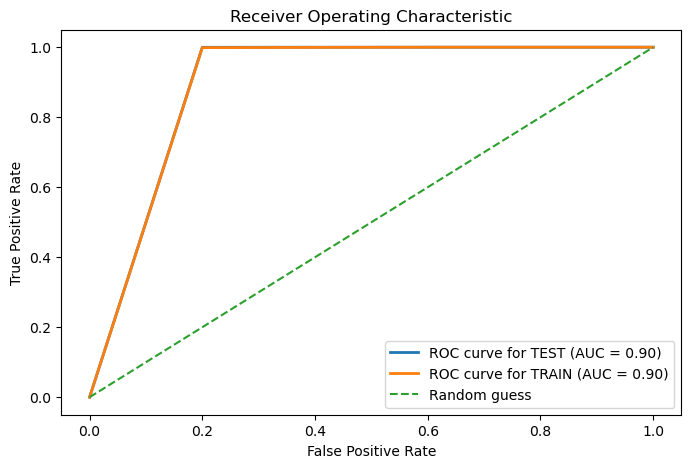

TRAINING classification report: 
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      6845
         1.0       0.99      1.00      1.00      7857

    accuracy                           0.99     14702
   macro avg       0.99      0.99      0.99     14702
weighted avg       0.99      0.99      0.99     14702


TESTING classification report: 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5156
         1.0       0.99      1.00      0.99      4141

    accuracy                           1.00      9297
   macro avg       1.00      1.00      1.00      9297
weighted avg       1.00      1.00      1.00      9297

Test accuracy: 1.00
>> Test precision: 1.00 <<
Test recall: 1.00
Test F1 score: 1.00
Test AUC score: 0.90


In [ ]:
# create the logistic regression model
lr_model = LogisticRegression()

# fit the model on the training data
lr_model.fit(X_train_scaled, y_train)

# display ROC curve and classification results
ROC(lr_model,X_train_scaled,X_test_scaled,y_train,y_test)

<Axes: >

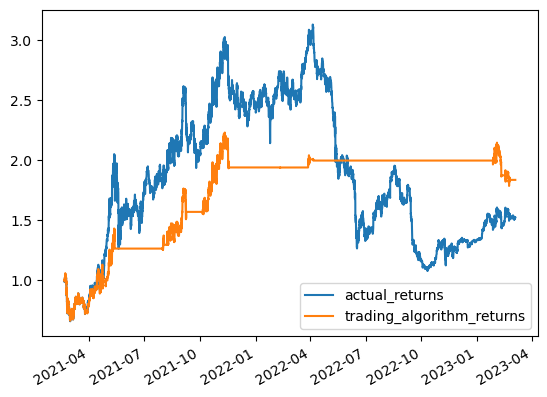

In [ ]:
# Define the trading fee as a decimal
trading_fee = 0.00075
classifier = lr_model

# Backtest using our exteranl function
lr_predictions_df = Backtesting (prep_df, X_test, X_test_scaled, classifier,trading_fee)

# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + lr_predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

In [ ]:
## Adding Short and Long strategy 

<Axes: >

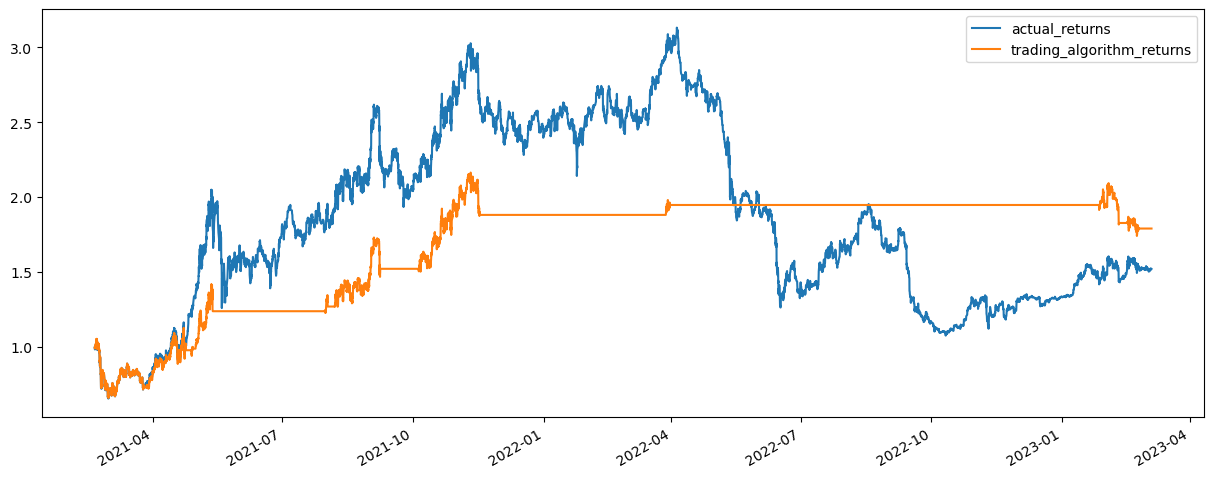

In [ ]:
lr_predictions_df['futures_predicted'] = lr_predictions_df['trading_algorithm_returns'].replace(0,-1)
lr_predictions_df['Strategy_Returns'] = lr_predictions_df["actual_returns"] * lr_predictions_df["futures_predicted"]

# Plot the actual returns versus the strategy returns
(1 + lr_predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot(figsize=(15,6))

---
## 5 Model Building helpers

These utilities below are helpful for identifying the best models and understanding them better. However, they may take a long time to run. If needed, you can interrupt their execution as they are not essential for the machine learning process.

### Selecting best performing model 

In [ ]:
model_selection(X_test_scaled,y_test)

Model Name  F1_Mean  F1_Standard Deviation
0  LinearDiscriminantAnalysis     1.00                  0.002
1        KNeighborsClassifier     1.00                  0.002
2      DecisionTreeClassifier     0.99                  0.003
3      RandomForestClassifier     1.00                  0.002
4        ExtraTreesClassifier     1.00                  0.002
5          AdaBoostClassifier     0.99                  0.002
6                         SVM     1.00                  0.002
7  GradientBoostingClassifier     1.00                  0.002
8                     XGBoost     1.00                  0.002

### SHAP Analysis 

In [ ]:
# Resample X_test
upscaled_X_test = X_test.resample('1D').interpolate(method='linear')


In [ ]:
# define which classifier to use 
clf = xgb_clf


# Initialize SHAP explainer
explainer = shap.Explainer(clf.predict, upscaled_X_test)

# Calculate SHAP values
shap_values = explainer(upscaled_X_test)

shap.summary_plot(shap_values, upscaled_X_test, plot_type="bar")

In [ ]:
# SHAP Analysis 
# define which classifier to use 
clf = cb_clf

# Initialize SHAP explainer
explainer = shap.Explainer(clf.predict, upscaled_X_test)

# Calculate SHAP values
shap_values = explainer(upscaled_X_test)

shap.summary_plot(shap_values, upscaled_X_test, plot_type="bar")